![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Healthcare/3.Clinical_Entity_Resolvers.ipynb)

In [2]:
import os

jsl_secret = os.getenv('SECRET')

import sparknlp
sparknlp_version = sparknlp.version()
import sparknlp_jsl
jsl_version = sparknlp_jsl.version()

print (jsl_secret)

In [3]:
import json
import os
from pyspark.ml import Pipeline, PipelineModel
from pyspark.sql import SparkSession

from sparknlp.annotator import *
from sparknlp_jsl.annotator import *
from sparknlp.base import *
from sparknlp.util import *
import sparknlp_jsl
import sparknlp

from sparknlp.pretrained import ResourceDownloader
from pyspark.sql import functions as F

params = {"spark.driver.memory":"16G",
"spark.kryoserializer.buffer.max":"2000M",
"spark.driver.maxResultSize":"2000M"}

spark = sparknlp_jsl.start(jsl_secret, params=params)

print ("Spark NLP Version :", sparknlp.version())
print ("Spark NLP_JSL Version :", sparknlp_jsl.version())

Spark NLP Version : 3.2.2
Spark NLP_JSL Version : 3.2.2


In [4]:
spark

# Sentence Entity Resolver Models

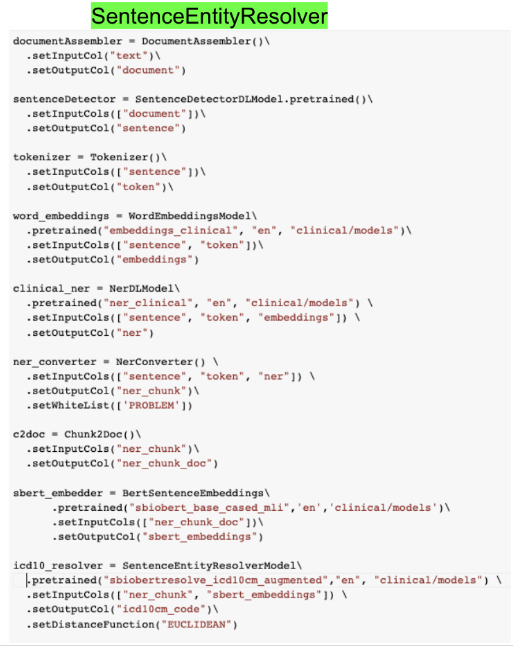

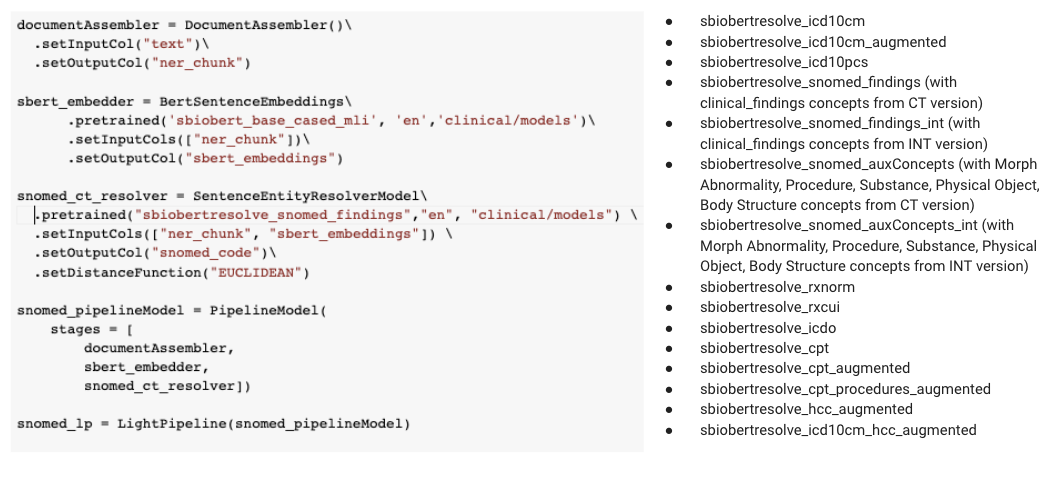

**Writing a Generic Function For Getting the Codes**

In [ ]:
import pandas as pd

pd.set_option('display.max_colwidth', 0)


def get_codes (lp, text, vocab='icd10cm_code', hcc=False):
    
    full_light_result = lp.fullAnnotate(text)

    chunks = []
    codes = []
    begin = []
    end = []
    resolutions=[]
    all_distances =[]
    all_codes=[]
    all_cosines = []
    all_k_aux_labels=[]

    for chunk, code in zip(full_light_result[0]['ner_chunk'], full_light_result[0][vocab]):
            
        begin.append(chunk.begin)
        end.append(chunk.end)
        chunks.append(chunk.result)
        codes.append(code.result) 
        all_codes.append(code.metadata['all_k_results'].split(':::'))
        resolutions.append(code.metadata['all_k_resolutions'].split(':::'))
        all_distances.append(code.metadata['all_k_distances'].split(':::'))
        all_cosines.append(code.metadata['all_k_cosine_distances'].split(':::'))
        if hcc:
            try:
                all_k_aux_labels.append(code.metadata['all_k_aux_labels'].split(':::'))
            except:
                all_k_aux_labels.append([])
        else:
            all_k_aux_labels.append([])

    df = pd.DataFrame({'chunks':chunks, 'begin': begin, 'end':end, 'code':codes, 'all_codes':all_codes, 
                       'resolutions':resolutions, 'all_k_aux_labels':all_k_aux_labels,'all_distances':all_cosines})
    
    if hcc:

        df['billable'] = df['all_k_aux_labels'].apply(lambda x: [i.split('||')[0] for i in x])
        df['hcc_status'] = df['all_k_aux_labels'].apply(lambda x: [i.split('||')[1] for i in x])
        df['hcc_score'] = df['all_k_aux_labels'].apply(lambda x: [i.split('||')[2] for i in x])

    df = df.drop(['all_k_aux_labels'], axis=1)
    
    return df



## Sentence Entity Resolver (RxNorm)

RxNorm is a second vocabulary for prescription drugs. RxNorm provides a set of codes for clinical drugs, which are the combination of active ingredients, dose form, and strength of a drug. For example, the RxNorm code for ciprofloxacin 500 mg 24-hour extended-release tablet (the generic name for Cipro XR 500 mg) is RX10359383, regardless of brand or packaging.

The goal of RxNorm is to allow computer systems to communicate drug-related information efficiently and unambiguously. Produced by the National Library of Medicine (NLM), RxNorm is available for distribution in both Metathesaurus Relation (MR) and Rich Release Format (RRF) tables. Currently there are no RxNorm names available for drugs with more than four active ingredients, those that are sold over the counter (OTC) or those that are international, due to the lack of appropriate information available about such drugs. 

In [ ]:
documentAssembler = DocumentAssembler()\
      .setInputCol("text")\
      .setOutputCol("ner_chunk")

sbert_embedder = BertSentenceEmbeddings.pretrained('sbiobert_base_cased_mli', 'en','clinical/models')\
      .setInputCols(["ner_chunk"])\
      .setOutputCol("sentence_embeddings")
    
rxnorm_resolver = SentenceEntityResolverModel.pretrained("sbiobertresolve_rxnorm","en", "clinical/models") \
      .setInputCols(["ner_chunk", "sentence_embeddings"]) \
      .setOutputCol("rxnorm_code")\
      .setDistanceFunction("EUCLIDEAN")

rxnorm_pipelineModel = PipelineModel(
    stages = [
        documentAssembler,
        sbert_embedder,
        rxnorm_resolver])

rxnorm_lp = LightPipeline(rxnorm_pipelineModel)


sbiobert_base_cased_mli download started this may take some time.
Approximate size to download 384.3 MB
[OK!]
sbiobertresolve_rxnorm download started this may take some time.
Approximate size to download 802.6 MB
[OK!]


In [ ]:
text = 'metformin 100 mg'

%time get_codes (rxnorm_lp, text, vocab='rxnorm_code')

CPU times: user 16.8 ms, sys: 13.4 ms, total: 30.1 ms
Wall time: 5.21 s


,chunks,begin,end,code,all_codes,resolutions,all_distances
0,metformin 100 mg,0,15,406081,"[406081, 576612, 403968, 861024, 404727, 334738, 332848, 861026, 333262, 439563, 450523, 1744000, 484793, 402346, 1726496, 316350, 858858, 336846, 316844, 1946837, 451225, 328507, 437723, 385601, 315677]","[metformin 100 mg/ml, metformin 100 mg/ml [riomet], metformin 100 mg/ml oral solution, metformin hydrochloride 100 mg/ml, metformin 100 mg/ml oral solution [riomet], fenofibrate 100 mg, ciprofibrate 100 mg, metformin hydrochloride 100 mg/ml [riomet], rutin 100 mg, fendiline 100 mg, perazine 100 mg, emtricitabine 100 mg, solifenacin 100 mg, miglustat 100 mg, azacitidine 100 mg, niacin 100 mg, carnosine 100 mg, trimebutine 100 mg, torsemide 100 mg, abemaciclib 100 mg, pyrantel 100 mg, rimantadine 100 mg, azintamide 100 mg, mebeverine 100 mg, cimetidine 100 mg]","[0.0235, 0.0376, 0.0505, 0.0658, 0.0670, 0.0684, 0.0697, 0.0770, 0.0765, 0.0775, 0.0804, 0.0818, 0.0807, 0.0811, 0.0812, 0.0811, 0.0828, 0.0844, 0.0846, 0.0840, 0.0844, 0.0850, 0.0851, 0.0851, 0.0876]"


In [ ]:
text = 'aspirin 10 meq/ 5 ml oral sol'

%time get_codes (rxnorm_lp, text, vocab='rxnorm_code')

CPU times: user 13.2 ms, sys: 8.06 ms, total: 21.3 ms
Wall time: 675 ms


,chunks,begin,end,code,all_codes,resolutions,all_distances
0,aspirin 10 meq/ 5 ml oral sol,0,28,104920,"[104920, 410146, 636574, 729048, 422031, 205247, 251102, 246529, 544468, 755941, 251830, 1117402, 422305, 241082, 245328, 604932, 247061, 604936, 2057152, 206399, 830193, 2057158, 252942, 794260, 428592]","[aspirin 500 mg / papaveretum 10 mg oral solution, cromoglicic acid 10 mg oral capsule, guaifenesin 10 mg/ml oral solution, pseudoephedrine tannate 10 mg/ml oral suspension, silymarin 10 mg/ml oral suspension, niacin 10 mg/ml oral solution, nimesulide 10 mg/ml oral suspension, midodrine 10 mg/ml oral solution, hypromellose 10 mg/ml oral solution, teferrol 10 mg/ml oral solution, mebeverine 10 mg/ml oral solution, guaifenesin 10 mg/ml oral solution [liqufruta], mebeverine 10 mg/ml oral suspension, methadyl acetate 10 mg/ml oral solution, cascara sagrada 10 mg/ml oral solution, ubidecarenone 10 mg/ml oral solution, periciazine 10 mg/ml oral solution, ubidecarenone 10 mg/ml oral solution [liquid co-q10], telmisartan 10 mg/ml oral solution, methadyl acetate 10 mg/ml oral solution [orlaam], opium tincture 10 mg/ml oral solution, telmisartan 10 mg/ml oral solution [semintra], bismuth subsalicylate 10 mg/ml oral suspension, ferrous sulfate 10 mg/ml oral solution, melitracen 10 mg / periciazine 0.5 mg oral tablet]","[0.0678, 0.0918, 0.0927, 0.0940, 0.0932, 0.0960, 0.0970, 0.0980, 0.1010, 0.0989, 0.1004, 0.1028, 0.1008, 0.0995, 0.1004, 0.1024, 0.1044, 0.1028, 0.1033, 0.1042, 0.1035, 0.1053, 0.1086, 0.1078, 0.1094]"


### RxNorm with DrugNormalizer

In [ ]:
documentAssembler = DocumentAssembler()\
      .setInputCol("text")\
      .setOutputCol("ner_chunk_v0")

drug_normalizer = DrugNormalizer() \
      .setInputCols("ner_chunk_v0") \
      .setOutputCol("ner_chunk") \
      .setPolicy('all')

rxnorm_pipelineModel2 = PipelineModel(
    stages = [
        documentAssembler,
        drug_normalizer,
        sbert_embedder,
        rxnorm_resolver])

rxnorm_lp2 = LightPipeline(rxnorm_pipelineModel2)

In [ ]:
text = 'aspirin 10 meq/ 5 ml oral sol'

%time get_codes (rxnorm_lp2, text, vocab='rxnorm_code')

CPU times: user 18.8 ms, sys: 2.51 ms, total: 21.3 ms
Wall time: 681 ms


,chunks,begin,end,code,all_codes,resolutions,all_distances
0,aspirin 2 meq/ml oral solution,0,29,688214,"[688214, 342917, 688213, 904947, 343786, 1192949, 755937, 756028, 104072, 343790, 246229, 755924, 309427, 755920, 756064, 756078, 607610, 756171, 1115998, 248847, 243387, 250944, 577157, 108870, 421803]","[aspirin 2.5 mg/ml oral solution, aspirin 2.2 mg/ml, aspirin 2.5 mg/ml, aspirin 2.7 mg/ml, aspirin 2.75 mg/ml, aspirin 2.71 mg/ml, periciazine 2 mg/ml oral solution, fenspiride 2 mg/ml oral solution, cimetidine 2 mg/ml oral solution, aspirin 2.12 mg/ml, thioridazine 2 mg/ml oral solution, carbetapentane 2 mg/ml oral solution, codeine 2 mg/ml oral solution, butamirate 2 mg/ml oral solution, oxeladin 2 mg/ml oral solution, pipazethate 2 mg/ml oral solution, memantine 2 mg/ml oral solution [namenda], selegiline 2 mg/ml oral solution, ephedrine sulfate 2.2 mg/ml oral solution, homatropine 2 mg/ml oral solution, docusate 2 mg/ml oral suspension, piracetam 2 mg/ml oral solution, memantine 2 mg/ml oral solution, theophylline 2 mg/ml oral solution, codeine 2 mg/ml oral suspension]","[0.0347, 0.0566, 0.0748, 0.0753, 0.0912, 0.0944, 0.0947, 0.1040, 0.1039, 0.1125, 0.1155, 0.1166, 0.1098, 0.1149, 0.1154, 0.1178, 0.1154, 0.1184, 0.1196, 0.1211, 0.1212, 0.1196, 0.1205, 0.1236, 0.1175]"


## Sentence Entity Resolver (ICD-10CM)

##  ICD10 background info

ICD-10-CM vs. ICD-10-PCS

With the transition to ICD-10, in the United States, ICD-9 codes are segmented into ICD-10-CM and ICD-10-PCS codes. **The "CM" in ICD-10-CM codes stands for clinical modification**; ICD-10-CM codes were developed by the Centers for Disease Control and Prevention in conjunction with the National Center for Health Statistics (NCHS), for outpatient medical coding and reporting in the United States, as published by the World Health Organization (WHO).

**The "PCS" in ICD-10-PCS codes stands for the procedural classification system**. ICD-10-PCS is a completely separate medical coding system from ICD-10-CM, containing an additional 87,000 codes for use ONLY in United States inpatient, hospital settings. The procedure classification system (ICD-10-PCS) was developed by the Centers for Medicare and Medicaid Services (CMS) in conjunction with 3M Health Information Management (HIM).

ICD-10-CM codes add increased specificity to their ICD-9 predecessors, growing to five times the number of codes as the present system; a total of 68,000 clinical modification diagnosis codes. ICD-10-CM codes provide the ability to track and reveal more information about the quality of healthcare, allowing healthcare providers to better understand medical complications, better design treatment and care, and better comprehend and determine the outcome of care.

ICD-10-PCS is used only for inpatient, hospital settings in the United States, and is meant to replace volume 3 of ICD-9 for facility reporting of inpatient procedures. Due to the rapid and constant state of flux in medical procedures and technology, ICD-10-PCS was developed to accommodate the changing landscape. Common procedures, lab tests, and educational sessions that are not unique to the inpatient, hospital setting have been omitted from ICD-10-PCS.

ICD-10 is confusing enough when you’re trying to digest the differences between ICD-9 and ICD-10, but there are also different types of ICD-10 codes that providers should be aware of.


**Primary difference between ICD-10-CM and ICD-10-PCS**

When most people talk about ICD-10, they are referring to ICD-10CM. This is the code set for diagnosis coding and is used for all healthcare settings in the United States. ICD-10PCS, on the other hand, is used in hospital inpatient settings for inpatient procedure coding.

ICD-10-CM breakdown

- Approximately 68,000 codes
- 3–7 alphanumeric characters
- Facilitates timely processing of claims


ICD-10-PCS breakdown

- Will replace ICD-9-CM for hospital inpatient use only. 
- ICD-10-PCS will not replace CPT codes used by physicians. According to HealthCare Information Management, Inc. (HCIM), “Its only intention is to identify inpatient facility services in a way not directly related to physician work, but directed towards allocation of hospital services.”

- 7 alphanumeric characters

ICD-10-PCS is very different from ICD-9-CM procedure coding due to its ability to be more specific and accurate. “This becomes increasingly important when assessing and tracking the quality of medical processes and outcomes, and compiling statistics that are valuable tools for research,” according to HCIM.

**Hierarchical Condition Category (HCC)**

Hierarchical condition category (HCC) coding is a risk-adjustment model originally designed to estimate future health care costs for patients. The Centers for Medicare & Medicaid Services (CMS) HCC model was initiated in 2004 but is becoming increasingly prevalent as the environment shifts to value-based payment models.

Hierarchical condition category relies on ICD-10 coding to assign risk scores to patients. Each HCC is mapped to an ICD-10 code. Along with demographic factors (such as age and gender), insurance companies use HCC coding to assign patients a risk adjustment factor (RAF) score. Using algorithms, insurances can use a patient’s RAF score to predict costs. For example, a patient with few serious health conditions could be expected to have average medical costs for a given time. However, a patient with multiple chronic conditions would be expected to have higher health care utilization and costs.

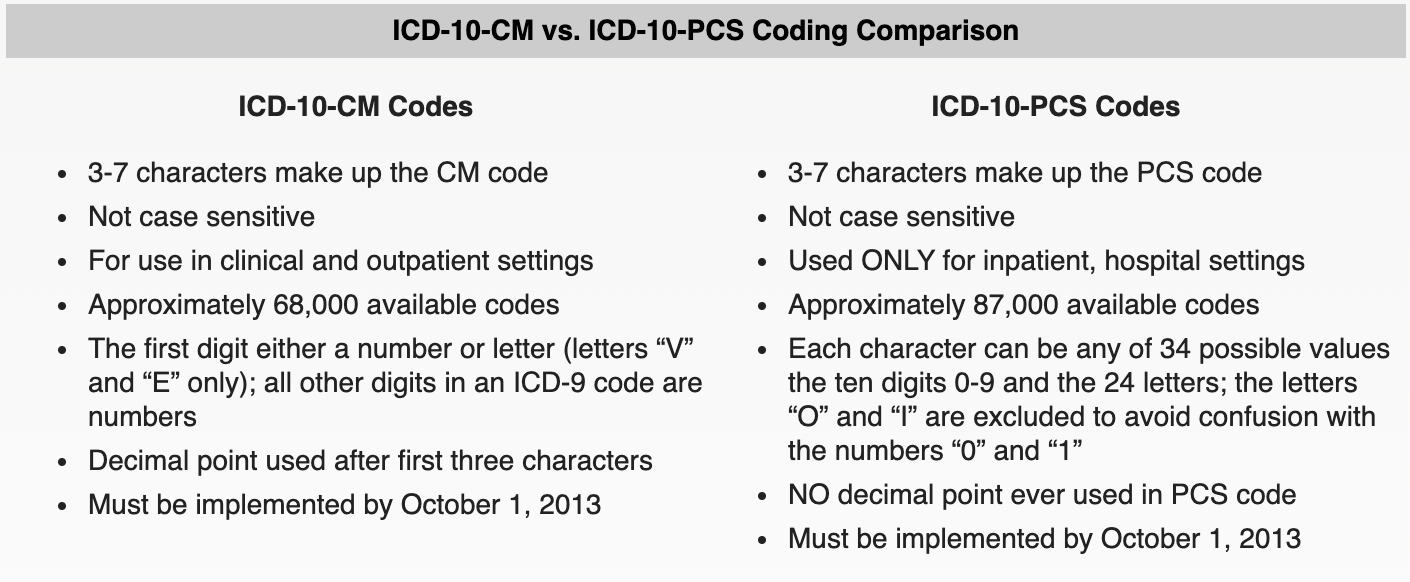

## ICD10 coding Pipeline creation.

A common NLP problem in biomedical aplications is to identify the presence of clinical entities in a given text. This clinical entities could be diseases, symptoms, drugs, results of clinical investigations or others.

To convert a sentence or document into a vector for semantic search or to build a recommendation system, one of the most popularly advised approaches is to pass the text through a transformer model like BERT, etc, and collect the embedding vector of CLS token or average out the embeddings of the tokens from the last layer to get a single vector.

Truth be told, this approach of finding similar documents through embedding the CLS token or average embedding of the last layer performs much worse than averaging of word2vec/Glove embedding to form a sentence/document vector.
On top of that, word2vec/Glove averaging is very fast to run when compared to extracting a vector through the transformer model.

A better approach for transformer-based embedding is to use fine-tuned Siamese network variants (SBERT etc) that are trained to embed similar sentences/ documents to a closer embedding space and separate the non-similar ones. That’s what we are doing here at Sentence Resolvers and it is why we outperform Chunk Resolvers.

Otherwise, the raw embedding vectors (CLS, etc) from the last layers of these transformer models don't yield any superior results for similarity search when compared to avg word2vec/Glove embeddings.

Here is a list of some of the sentence entity resolver models;

- sbiobertresolve_icd10cm 
- sbiobertresolve_icd10cm_augmented
- sbiobertresolve_hcc_augmented
- sbiobertresolve_icd10cm_augmented_billable_hcc
- sbertresolve_icd10cm_slim_billable_hcc_med
- sbiobertresolve_icd10cm_slim_billable_hcc
- sbiobertresolve_icd10pcs
- sbiobertresolve_snomed_findings (with clinical_findings concepts from CT version)
- sbiobertresolve_snomed_findings_int  (with clinical_findings concepts from INT version)
- sbiobertresolve_snomed_auxConcepts (with Morph Abnormality, Procedure, Substance, Physical Object, Body Structure concepts from CT version)
- sbiobertresolve_snomed_auxConcepts_int  (with Morph Abnormality, Procedure, Substance, Physical Object, Body Structure concepts from INT version)
- sbertresolve_snomed_bodyStructure_med
- sbiobertresolve_rxnorm
- sbiobertresolve_rxcui
- sbiobertresolve_icdo
- sbiobertresolve_icdo_augmented
- sbiobertresolve_cpt
- sbiobertresolve_cpt_procedures_augmented
- sbiobertresolve_loinc
- sbiobertresolve_HPO
- sbiobertresolve_umls_major_concepts
- sbiobertresolve_umls_findings

Other than providing the code in the "result" field it provides more metadata about the matching process:

- target_text -> Text to resolve
- resolved_text -> Best match text
- confidence -> Relative confidence for the top match (distance to probability)
- confidence_ratio -> Relative confidence for the top match. TopMatchConfidence / SecondMatchConfidence
- alternative_codes -> List of other plausible codes (in the KNN neighborhood)
- all_k_resolutions -> All codes descriptions
- all_k_results -> All resolved codes for metrics calculation purposes
- sentence -> SentenceId

We will now create a new pipeline that from each of these problems will try to assign an ICD10 base on the content, the sentence embeddings and some pretrained models for ICD10 annotation.

The architecture of this new pipeline will be as follows:

- DocumentAssembler (text -> document)

- SentenceDetector (document -> sentence)

- Tokenizer (sentence -> token)

- WordEmbeddingsModel ([sentence, token] -> embeddings)

- MedicalNerModel ([sentence, token, embeddings] -> ner)

- NerConverter (["sentence, token, ner] -> ner_chunk

- Chunk2Doc (ner_chunk) -> ner_chunk_doc

- BertSentenceEmbeddings (ner_chunk_doc) -> sbert_embeddings

- SentenceEntityResolverModel ([ner_chunk, sbert_embeddings] -> resolution)

So from a text we end having a list of Named Entities (ner_chunk) and their ICD10 codes (resolution)

Most of the annotators in this pipeline have been already created for the previous pipeline, but we need to create four additional annotators: NerConverter, Chunk2Doc, BertSentenceEmbeddings,  SentenceEntityResolverModel for ICD10CM.

`setPreservePosition(True)` takes exactly the original indices (under some tokenization conditions it might include some undesires chars like `")","]"...)`

`setPreservePosition(False)` takes adjusted indices based on substring indexingOf the first (for begin) and last (for end) tokens

also with internal we can use the `greedyMode` which will marge consecutive entities of same type regardless of b-boundaries


<h1>!!! Warning !!!</h1> 

**If you get an error related to Java port not found 55, it is probably because that the Colab memory cannot handle the model and the Spark session died. In that case, try on a larger machine or restart the kernel at the top and then come back here and rerun.**

In [ ]:
# Annotator that transforms a text column from dataframe into an Annotation ready for NLP
document_assembler = DocumentAssembler()\
      .setInputCol("text")\
      .setOutputCol("document")

# Sentence Detector DL annotator, processes various sentences per line
sentenceDetectorDL = SentenceDetectorDLModel.pretrained("sentence_detector_dl_healthcare", "en", 'clinical/models') \
      .setInputCols(["document"]) \
      .setOutputCol("sentence")

# Tokenizer splits words in a relevant format for NLP
tokenizer = Tokenizer()\
      .setInputCols(["sentence"])\
      .setOutputCol("token")

# WordEmbeddingsModel pretrained "embeddings_clinical" includes a model of 1.7Gb that needs to be downloaded
word_embeddings = WordEmbeddingsModel.pretrained("embeddings_clinical", "en", "clinical/models")\
  .setInputCols(["sentence", "token"])\
  .setOutputCol("word_embeddings")

# Named Entity Recognition for clinical concepts.
clinical_ner = MedicalNerModel.pretrained("ner_clinical", "en", "clinical/models") \
      .setInputCols(["sentence", "token", "word_embeddings"]) \
      .setOutputCol("ner")

ner_converter_icd = NerConverterInternal() \
      .setInputCols(["sentence", "token", "ner"]) \
      .setOutputCol("ner_chunk")\
      .setWhiteList(['problem'])\
      .setPreservePosition(False)

c2doc = Chunk2Doc()\
      .setInputCols("ner_chunk")\
      .setOutputCol("ner_chunk_doc") 

sbert_embedder = BertSentenceEmbeddings.pretrained('sbiobert_base_cased_mli', 'en','clinical/models')\
      .setInputCols(["ner_chunk_doc"])\
      .setOutputCol("sentence_embeddings")
    
icd_resolver = SentenceEntityResolverModel.pretrained("sbiobertresolve_icd10cm_augmented_billable_hcc","en", "clinical/models") \
     .setInputCols(["ner_chunk", "sentence_embeddings"]) \
     .setOutputCol("icd10cm_code")\
     .setDistanceFunction("EUCLIDEAN")
    

# Build up the pipeline
resolver_pipeline = Pipeline(
    stages = [
        document_assembler,
        sentenceDetectorDL,
        tokenizer,
        word_embeddings,
        clinical_ner,
        ner_converter_icd,
        c2doc,
        sbert_embedder,
        icd_resolver
  ])


empty_data = spark.createDataFrame([['']]).toDF("text")

model = resolver_pipeline.fit(empty_data)

sentence_detector_dl_healthcare download started this may take some time.
Approximate size to download 367.3 KB
[OK!]
embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]
ner_clinical download started this may take some time.
Approximate size to download 13.9 MB
[OK!]
sbiobert_base_cased_mli download started this may take some time.
Approximate size to download 384.3 MB
[OK!]
sbiobertresolve_icd10cm_augmented_billable_hcc download started this may take some time.
Approximate size to download 1.4 GB
[OK!]


### Create a SparkDataFrame with the content

Now we will create a sample Spark dataframe with our clinical note example.

In this example we are working over a unique clinical note. In production environments a table with several of those clinical notes could be distributed in a cluster and be run in large scale systems.

In [ ]:
clinical_note = (
    'A 28-year-old female with a history of gestational diabetes mellitus diagnosed eight years '
    'prior to presentation and subsequent type two diabetes mellitus (T2DM), one prior '
    'episode of HTG-induced pancreatitis three years prior to presentation, associated '
    'with an acute hepatitis, and obesity with a body mass index (BMI) of 33.5 kg/m2, '
    'presented with a one-week history of polyuria, polydipsia, poor appetite, and vomiting. '
    'Two weeks prior to presentation, she was treated with a five-day course of amoxicillin '
    'for a respiratory tract infection. She was on metformin, glipizide, and dapagliflozin '
    'for T2DM and atorvastatin and gemfibrozil for HTG. She had been on dapagliflozin for six months '
    'at the time of presentation. Physical examination on presentation was significant for dry oral mucosa; '
    'significantly, her abdominal examination was benign with no tenderness, guarding, or rigidity. Pertinent '
    'laboratory findings on admission were: serum glucose 111 mg/dl, bicarbonate 18 mmol/l, anion gap 20, '
    'creatinine 0.4 mg/dL, triglycerides 508 mg/dL, total cholesterol 122 mg/dL, glycated hemoglobin (HbA1c) '
    '10%, and venous pH 7.27. Serum lipase was normal at 43 U/L. Serum acetone levels could not be assessed '
    'as blood samples kept hemolyzing due to significant lipemia. The patient was initially admitted for '
    'starvation ketosis, as she reported poor oral intake for three days prior to admission. However, '
    'serum chemistry obtained six hours after presentation revealed her glucose was 186 mg/dL, the anion gap '
    'was still elevated at 21, serum bicarbonate was 16 mmol/L, triglyceride level peaked at 2050 mg/dL, and '
    'lipase was 52 U/L. The β-hydroxybutyrate level was obtained and found to be elevated at 5.29 mmol/L - '
    'the original sample was centrifuged and the chylomicron layer removed prior to analysis due to '
    'interference from turbidity caused by lipemia again. The patient was treated with an insulin drip '
    'for euDKA and HTG with a reduction in the anion gap to 13 and triglycerides to 1400 mg/dL, within '
    '24 hours. Her euDKA was thought to be precipitated by her respiratory tract infection in the setting '
    'of SGLT2 inhibitor use. The patient was seen by the endocrinology service and she was discharged on '
    '40 units of insulin glargine at night, 12 units of insulin lispro with meals, and metformin 1000 mg '
    'two times a day. It was determined that all SGLT2 inhibitors should be discontinued indefinitely. She '
    'had close follow-up with endocrinology post discharge.'
)

data_ner = spark.createDataFrame([[clinical_note]]).toDF("text")

In [ ]:
data_ner.show(truncate = 100)


+----------------------------------------------------------------------------------------------------+
|                                                                                                text|
+----------------------------------------------------------------------------------------------------+
|A 28-year-old female with a history of gestational diabetes mellitus diagnosed eight years prior ...|
+----------------------------------------------------------------------------------------------------+



In [ ]:
icd10_result = model.transform(data_ner)

In [ ]:
%time icd10_result.select("icd10cm_code.metadata").show(truncate=100)

+----------------------------------------------------------------------------------------------------+
|                                                                                            metadata|
+----------------------------------------------------------------------------------------------------+
|[{chunk -> 0, all_k_results -> O2441:::O2443:::Z8632:::Z875:::O2431:::O2411:::O244:::O241:::O2481...|
+----------------------------------------------------------------------------------------------------+

CPU times: user 7.62 ms, sys: 2.64 ms, total: 10.3 ms
Wall time: 36.8 s


In [ ]:
pd.set_option("display.max_colwidth",0)

In [ ]:
import pandas as pd

pd.set_option('display.max_colwidth', 0)

def get_codes_from_df(result_df, chunk, output_col, hcc= False):
    
    
    if hcc:
        
        df = result_df.select(F.explode(F.arrays_zip(chunk+'.result', 
                                                           chunk+'.metadata', 
                                                           output_col+'.result', 
                                                           output_col+'.metadata')).alias("cols")) \
                                     .select(F.expr("cols['1']['sentence']").alias("sent_id"),
                                             F.expr("cols['0']").alias("ner_chunk"),
                                             F.expr("cols['1']['entity']").alias("entity"), 
                                             F.expr("cols['2']").alias("icd10_code"),
                                             F.expr("cols['3']['all_k_results']").alias("all_codes"),
                                             F.expr("cols['3']['all_k_resolutions']").alias("resolutions"),
                                             F.expr("cols['3']['all_k_aux_labels']").alias("hcc_list")).toPandas()



        codes = []
        resolutions = []
        hcc_all = []

        for code, resolution, hcc in zip(df['all_codes'], df['resolutions'], df['hcc_list']):

            codes.append(code.split(':::'))
            resolutions.append(resolution.split(':::'))
            hcc_all.append(hcc.split(":::"))

        df['all_codes'] = codes  
        df['resolutions'] = resolutions
        df['hcc_list'] = hcc_all
        
    else:
                       
        df = result_df.select(F.explode(F.arrays_zip(chunk+'.result', 
                                                           chunk+'.metadata', 
                                                           output_col+'.result', 
                                                           output_col+'.metadata')).alias("cols")) \
                                     .select(F.expr("cols['1']['sentence']").alias("sent_id"),
                                             F.expr("cols['0']").alias("ner_chunk"),
                                             F.expr("cols['1']['entity']").alias("entity"), 
                                             F.expr("cols['2']").alias("icd10_code"),
                                             F.expr("cols['3']['all_k_results']").alias("all_codes"),
                                             F.expr("cols['3']['all_k_resolutions']").alias("resolutions")).toPandas()



        codes = []
        resolutions = []

        for code, resolution in zip(df['all_codes'], df['resolutions']):

            codes.append(code.split(':::'))
            resolutions.append(resolution.split(':::'))

        df['all_codes'] = codes  
        df['resolutions'] = resolutions
        
    
    return df

In [ ]:
%%time

res_pd = get_codes_from_df(icd10_result, 'ner_chunk', 'icd10cm_code', hcc=True)
res_pd.head(10)

CPU times: user 63.5 ms, sys: 12.7 ms, total: 76.2 ms
Wall time: 3min 53s


,sent_id,ner_chunk,entity,icd10_code,all_codes,resolutions,hcc_list
0,0,gestational diabetes mellitus,PROBLEM,O2441,"[O2441, O2443, Z8632, Z875, O2431, O2411, O244, O241, O2481]","[gestational diabetes mellitus, postpartum gestational diabetes mellitus, history of gestational diabetes mellitus, history of gestational diabetes mellitus (situation), pre-existing diabetes mellitus in pregnancy, pre-existing diabetes mellitus in pregnancy (disorder), postpartum gestational diabetes mellitus (disorder), pre-existing type 2 diabetes mellitus in pregnancy, other pre-existing diabetes mellitus in pregnancy]","[0||0||0, 0||0||0, 1||0||0, 0||0||0, 0||0||0, 0||0||0, 0||0||0, 0||0||0, 0||0||0]"
1,0,subsequent type two diabetes mellitus,PROBLEM,O2411,"[O2411, E118, E11, E119, E139, E113, E1144, Z863, Z8639, E1132, E1143, E117]","[pre-existing type 2 diabetes mellitus, disorder associated with type 2 diabetes mellitus, type 2 diabetes mellitus, type 2 diabetes mellitus, secondary diabetes mellitus, disorder of eye due to type 2 diabetes mellitus, disorder of nervous system due to type 2 diabetes mellitus, history of diabetes mellitus type 2 (situation), history of diabetes mellitus type 2, secondary endocrine diabetes mellitus, neurological disorder with type 2 diabetes mellitus, multiple complications of type 2 diabetes mellitus]","[0||0||0, 1||1||18, 0||0||0, 1||1||19, 1||1||19, 0||0||0, 1||1||75/18, 0||0||0, 1||0||0, 0||1||18, 1||1||75/18, 1||0||0]"
2,0,T2DM,PROBLEM,E11,"[E11, E119, E118, O2411, E109, E139, E113, E148, E149, E8881, Z833, E117, D649, Z863]","[type 2 diabetes mellitus, type 2 diabetes mellitus, disorder associated with type 2 diabetes mellitus, pre-existing type 2 diabetes mellitus, diabetes mellitus, secondary diabetes mellitus, disorder of eye with type 2 diabetes mellitus, disorder associated with diabetes mellitus, dm - diabetes mellitus, insulin resistance in diabetes, fh: diabetes mellitus, multiple complications of type 2 diabetes mellitus, anemia of diabetes, h/o: diabetes mellitus]","[0||0||0, 1||1||19, 1||1||18, 0||0||0, 1||1||19, 1||1||19, 0||0||0, 1||0||0, 1||0||0, 1||0||0, 1||0||0, 1||0||0, 1||0||0, 0||0||0]"
3,0,HTG-induced pancreatitis,PROBLEM,K8520,"[K8520, K853, K8590, F102, K852, K859, K8580, K8591, K858, K918, K85, K8510]","[alcohol-induced pancreatitis, drug-induced acute pancreatitis, hemorrhagic pancreatitis, alcohol-induced chronic pancreatitis, alcohol-induced acute pancreatitis (disorder), pancreatitis, traumatic acute pancreatitis (disorder), necrotizing pancreatitis, traumatic acute pancreatitis, post-ercp acute pancreatitis, acute pancreatitis, gallstone acute pancreatitis]","[1||0||0, 0||0||0, 1||0||0, 0||0||0, 0||0||0, 0||0||0, 1||0||0, 1||0||0, 0||0||0, 0||0||0, 0||0||0, 1||0||0]"
4,0,an acute hepatitis,PROBLEM,B159,"[B159, B15, K720, B179, B172, Z0389, K752, K712, B199, B161, B16]","[acute hepatitis a, acute hepatitis a, acute hepatitis, acute infectious hepatitis, acute hepatitis e, acute infectious hepatitis suspected, acute focal hepatitis, toxic liver disease with acute hepatitis, fulminant hepatitis, acute hepatitis b, acute hepatitis b]","[1||0||0, 0||0||0, 0||0||0, 1||0||0, 1||0||0, 1||0||0, 1||0||0, 1||0||0, 1||0||0, 1||0||0, 0||0||0]"
5,0,obesity,PROBLEM,E669,"[E669, E668, Z6841, Q130, E66, E6601, Z8639, E349, H3550, Z8349, Q5562]","[obesity, abdominal obesity, obese, central obesity, overweight and obesity, morbid obesity, h/o: obesity, severe obesity, centripetal obesity, fh: obesity, truncal obesity]","[1||0||0, 1||0||0, 1||1||22, 1||0||0, 0||0||0, 1||1||22, 1||0||0, 1||0||0, 1||0||0, 1||0||0, 1||0||0]"
6,0,a body mass index,PROBLEM,Z6841,"[Z6841, E669, R229, Z681, R223, R221, Z68, R222, R220, R4189, M6258, P299, R1900, R898, M2170, R190, M2180]","[finding of body mass index, observation of body mass index, mass of body region, finding of body mass index (finding), mass of upper limb, head and neck mass, body mass index [bmi], mass of trunk, mass of head, preoccupation with body 

**The values in `billable`, `hcc_score` and `hcc_status` columns are seperated by || and we will change them to a list.**

In [ ]:
def extract_billable(bil):
  
    billable = []
    status = []
    score = []
 
    for b in bil:
        billable.append(b.split("||")[0])
        status.append(b.split("||")[1])
        score.append(b.split("||")[2])

    return (billable, status, score)

In [ ]:
res_pd["billable"] = res_pd["hcc_list"].apply(extract_billable).apply(pd.Series).iloc[:,0]    
res_pd["hcc_status"] = res_pd["hcc_list"].apply(extract_billable).apply(pd.Series).iloc[:,1]
res_pd["hcc_score"] = res_pd["hcc_list"].apply(extract_billable).apply(pd.Series).iloc[:,2]

res_pd.drop("hcc_list", axis=1, inplace= True)

In [ ]:
res_pd.head(15)

,sent_id,ner_chunk,entity,icd10_code,all_codes,resolutions,billable,hcc_status,hcc_score
0,0,gestational diabetes mellitus,PROBLEM,O2441,"[O2441, O2443, Z8632, Z875, O2431, O2411, O244, O241, O2481]","[gestational diabetes mellitus, postpartum gestational diabetes mellitus, history of gestational diabetes mellitus, history of gestational diabetes mellitus (situation), pre-existing diabetes mellitus in pregnancy, pre-existing diabetes mellitus in pregnancy (disorder), postpartum gestational diabetes mellitus (disorder), pre-existing type 2 diabetes mellitus in pregnancy, other pre-existing diabetes mellitus in pregnancy]","[0, 0, 1, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0]"
1,0,subsequent type two diabetes mellitus,PROBLEM,O2411,"[O2411, E118, E11, E119, E139, E113, E1144, Z863, Z8639, E1132, E1143, E117]","[pre-existing type 2 diabetes mellitus, disorder associated with type 2 diabetes mellitus, type 2 diabetes mellitus, type 2 diabetes mellitus, secondary diabetes mellitus, disorder of eye due to type 2 diabetes mellitus, disorder of nervous system due to type 2 diabetes mellitus, history of diabetes mellitus type 2 (situation), history of diabetes mellitus type 2, secondary endocrine diabetes mellitus, neurological disorder with type 2 diabetes mellitus, multiple complications of type 2 diabetes mellitus]","[0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1]","[0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0]","[0, 18, 0, 19, 19, 0, 75/18, 0, 0, 18, 75/18, 0]"
2,0,T2DM,PROBLEM,E11,"[E11, E119, E118, O2411, E109, E139, E113, E148, E149, E8881, Z833, E117, D649, Z863]","[type 2 diabetes mellitus, type 2 diabetes mellitus, disorder associated with type 2 diabetes mellitus, pre-existing type 2 diabetes mellitus, diabetes mellitus, secondary diabetes mellitus, disorder of eye with type 2 diabetes mellitus, disorder associated with diabetes mellitus, dm - diabetes mellitus, insulin resistance in diabetes, fh: diabetes mellitus, multiple complications of type 2 diabetes mellitus, anemia of diabetes, h/o: diabetes mellitus]","[0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0]","[0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 19, 18, 0, 19, 19, 0, 0, 0, 0, 0, 0, 0, 0]"
3,0,HTG-induced pancreatitis,PROBLEM,K8520,"[K8520, K853, K8590, F102, K852, K859, K8580, K8591, K858, K918, K85, K8510]","[alcohol-induced pancreatitis, drug-induced acute pancreatitis, hemorrhagic pancreatitis, alcohol-induced chronic pancreatitis, alcohol-induced acute pancreatitis (disorder), pancreatitis, traumatic acute pancreatitis (disorder), necrotizing pancreatitis, traumatic acute pancreatitis, post-ercp acute pancreatitis, acute pancreatitis, gallstone acute pancreatitis]","[1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
4,0,an acute hepatitis,PROBLEM,B159,"[B159, B15, K720, B179, B172, Z0389, K752, K712, B199, B161, B16]","[acute hepatitis a, acute hepatitis a, acute hepatitis, acute infectious hepatitis, acute hepatitis e, acute infectious hepatitis suspected, acute focal hepatitis, toxic liver disease with acute hepatitis, fulminant hepatitis, acute hepatitis b, acute hepatitis b]","[1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
5,0,obesity,PROBLEM,E669,"[E669, E668, Z6841, Q130, E66, E6601, Z8639, E349, H3550, Z8349, Q5562]","[obesity, abdominal obesity, obese, central obesity, overweight and obesity, morbid obesity, h/o: obesity, severe obesity, centripetal obesity, fh: obesity, truncal obesity]","[1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1]","[0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0]","[0, 0, 22, 0, 0, 22, 0, 0, 0, 0, 0]"
6,0,a body mass index,PROBLEM,Z6841,"[Z6841, E669, R229, Z681, R223, R221, Z68, R222, R220, R4189, M6258, P299, R1900, R898, M2170, R190, M2180]","[finding of body mass index, observation of body mass index, mass of body region, finding of body mass index (finding), mass of upper limb, head and neck mass, body mass index [bm

Lets apply some HTML formating by using `sparknlp_display` library to see the results of the pipeline in a nicer layout:

In [ ]:
from sparknlp_display import EntityResolverVisualizer

icd10_lp = LightPipeline(model)

light_result = icd10_lp.fullAnnotate(clinical_note)

visualiser = EntityResolverVisualizer()

# Change color of an entity label
visualiser.set_label_colors({'PROBLEM':'#008080'})

visualiser.display(light_result[0], 'ner_chunk', 'icd10cm_code')

## BertSentenceChunkEmbeddings

This annotator let users to aggregate sentence embeddings and ner chunk embeddings to get more specific and accurate resolution codes. It works by averaging context and chunk embeddings to get contextual information. Input to this annotator is the context (sentence) and ner chunks, while the output is embedding for each chunk that can be fed to the resolver model. The `setChunkWeight` parameter can be used to control the influence of surrounding context.

For more information and examples of `BertSentenceChunkEmbeddings` annotator, you can check here: 
[24.1.Improved_Entity_Resolution_with_SentenceChunkEmbeddings.ipynb](https://github.com/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Healthcare/24.1.Improved_Entity_Resolution_with_SentenceChunkEmbeddings.ipynb)

### ICD10CM with BertSentenceChunkEmbeddings

Lets do the same process by using `BertSentenceEmbeddings` annotator and compare the results. We will create a new pipeline by using this annotator with SentenceEntityResolverModel.

In [ ]:
#Get average sentence-chunk Bert embeddings
sentence_chunk_embeddings = BertSentenceChunkEmbeddings.pretrained("sbiobert_base_cased_mli", "en", "clinical/models")\
    .setInputCols(["sentence", "ner_chunk"])\
    .setOutputCol("sentence_embeddings")\
    .setChunkWeight(0.5) #default : 0.5

    
icd_resolver = SentenceEntityResolverModel.pretrained("sbiobertresolve_icd10cm_augmented_billable_hcc","en", "clinical/models") \
     .setInputCols(["ner_chunk", "sentence_embeddings"]) \
     .setOutputCol("icd10cm_code")\
     .setDistanceFunction("EUCLIDEAN")
    

resolver_pipeline_SCE = Pipeline(
    stages = [
        document_assembler,
        sentenceDetectorDL,
        tokenizer,
        word_embeddings,
        clinical_ner,
        ner_converter_icd,
        sentence_chunk_embeddings,
        icd_resolver
  ])


empty_data = spark.createDataFrame([['']]).toDF("text")
model_SCE = resolver_pipeline_SCE.fit(empty_data)

sbiobert_base_cased_mli download started this may take some time.
Approximate size to download 384.3 MB
[OK!]
sbiobertresolve_icd10cm_augmented_billable_hcc download started this may take some time.
Approximate size to download 1.4 GB
[OK!]


In [ ]:
model.stages

[DocumentAssembler_7e90dd1336dd,
 SentenceDetectorDLModel_6bafc4746ea5,
 REGEX_TOKENIZER_c810f4b0df14,
 WORD_EMBEDDINGS_MODEL_9004b1d00302,
 MedicalNerModel_cd5ce67b529f,
 NerConverterInternal_38500db4e3a2,
 Chunk2Doc_bf4974d3077d,
 BERT_SENTENCE_EMBEDDINGS_0bee53f1b2cc,
 ENTITY_897a598af3c6]

In [ ]:
model_SCE.stages

[DocumentAssembler_7e90dd1336dd,
 SentenceDetectorDLModel_6bafc4746ea5,
 REGEX_TOKENIZER_f6d95ebb776f,
 WORD_EMBEDDINGS_MODEL_9004b1d00302,
 MedicalNerModel_cd5ce67b529f,
 NerConverterInternal_38500db4e3a2,
 BERTSENTENCECHUNKEMBEDDINGS_6cf86175cf05,
 ENTITY_897a598af3c6]

In [ ]:
icd10_result_SCE = model_SCE.transform(data_ner)

In [ ]:
%%time

res_SCE_pd = get_codes_from_df(icd10_result_SCE, 'ner_chunk', 'icd10cm_code', hcc=True)

res_SCE_pd["billable"] = res_SCE_pd["hcc_list"].apply(extract_billable).apply(pd.Series).iloc[:,0]    
res_SCE_pd["hcc_status"] = res_SCE_pd["hcc_list"].apply(extract_billable).apply(pd.Series).iloc[:,1]
res_SCE_pd["hcc_score"] = res_SCE_pd["hcc_list"].apply(extract_billable).apply(pd.Series).iloc[:,2]

res_SCE_pd.drop("hcc_list", axis=1, inplace= True)

CPU times: user 114 ms, sys: 16.9 ms, total: 131 ms
Wall time: 3min 4s


In [ ]:
res_SCE_pd.head(15)

,sent_id,ner_chunk,entity,icd10_code,all_codes,resolutions,billable,hcc_status,hcc_score
0,0,gestational diabetes mellitus,PROBLEM,O244,"[O244, O2443, O2441, O2442, O2413]","[gestational diabetes mellitus, class d, gestational diabetes mellitus in the puerperium, gestational diabetes mellitus, class a>1<, gestational diabetes mellitus in childbirth, pre-existing type 2 diabetes mellitus, in the puerperium]","[0, 0, 0, 0, 1]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]"
1,0,subsequent type two diabetes mellitus,PROBLEM,O2413,"[O2413, E116, E1143, O2411, E1110, E1133, O241, E114, O2412, E111, E1169, E113, K318, E112, O244, H211X, E109, E1129, E162]","[pre-existing type 2 diabetes mellitus, in the puerperium, gastroparesis co-occurrent and due to type 2 diabetes mellitus, gastroparesis with type 2 diabetes mellitus, pregnancy and type 2 diabetes mellitus, ketoacidosis due to type 2 diabetes mellitus, moderate nonproliferative retinopathy co-occurrent and due to type 2 diabetes mellitus, pre-existing type 2 diabetes mellitus in pregnancy, cranial nerve palsy co-occurrent and due to type 2 diabetes mellitus, pre-existing type 2 diabetes mellitus, in childbirth, ketoacidosis due to type 2 diabetes mellitus (disorder), angina due to type 2 diabetes mellitus, rubeosis iridis co-occurrent and due to type 2 diabetes mellitus, diabetic gastroparesis associated with type 2 diabetes mellitus, persistent microalbuminuria due to type 2 diabetes mellitus, gestational diabetes mellitus, class d, rubeosis iridis due to type 2 diabetes mellitus, acanthosis nigricans due to type 2 diabetes mellitus, persistent microalbuminuria due to type 2 diabetes mellitus (disorder), post hypoglycemic hyperglycemia due to diabetes mellitus]","[1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1]","[0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0]","[0, 0, 75/18, 0, 17, 18, 0, 0, 0, 0, 18, 0, 0, 0, 0, 0, 19, 141/18, 0]"
2,0,T2DM,PROBLEM,O244,"[O244, O2413, O2411, L83, O241, E1143, E119, E113, O2441, O2412, E116, E109, E1169, E113553, E1135, E1110]","[gestational diabetes mellitus, class a>2<, pre-existing type 2 diabetes mellitus, in the puerperium, pregnancy and type 2 diabetes mellitus, type 2 diabetes mellitus with acanthosis nigricans, pre-existing type 2 diabetes mellitus in pregnancy, gastroparesis with type 2 diabetes mellitus, type 2 diabetes mellitus in obese, rubeosis iridis with type 2 diabetes mellitus, gestational diabetes mellitus, class a>1<, pre-existing type 2 diabetes mellitus, in childbirth, gastroparesis co-occurrent and due to type 2 diabetes mellitus, acanthosis nigricans due to type 2 diabetes mellitus, diabetes mellitus type 2 in obese (disorder), type 2 diabetes with stable prolif diabetic rtnop, bilateral, type 2 diabetes with stable prolif diabetic rtnop, bilateral, ketoacidosis in type 2 diabetes mellitus]","[0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1]","[0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1]","[0, 0, 0, 0, 0, 75/18, 19, 0, 0, 0, 0, 19, 18, 0, 122/18, 17]"
3,0,HTG-induced pancreatitis,PROBLEM,E139,"[E139, E1069, Z924, K903, K8532, E104, K918, K8502, K8522, K318, K8512, E1143, E46, K8510, E106, E091, K8590, E1043]","[congenital insulin-dependent diabetes mellitus with fatal secretory diarrhea, congenital insulin-dependent diabetes mellitus with fatal secretory diarrhoea, postprocedural pancreatic steatorrhea, postprocedural pancreatic steatorrhea (disorder), drug induced acute pancreatitis with infected necrosis, diabetes type 1 with gastroparesis, post-endoscopic retrograde cholangiopancreatography acute pancreatitis (disorder), idiopathic acute pancreatitis with infected necrosis, alcohol induced acute pancreatitis with infected necrosis, gastroparesis due to diabetes mellitus type i, biliary acute pancreatitis with infected necrosis, gastroparesis due to diabetes mellitus type ii, ketoacidosis due to malnutrition related diabetes mellitus (disorder), gallstone acute pancreatitis (disorder), gastroparesis due to typ

Lets show the results on the raw text.

In [ ]:
icd10_SCE_lp = LightPipeline(model_SCE)

light_result = icd10_SCE_lp.fullAnnotate(clinical_note)

visualiser = EntityResolverVisualizer()

# Change color of an entity label
visualiser.set_label_colors({'PROBLEM':'#008080'})

visualiser.display(light_result[0], 'ner_chunk', 'icd10cm_code')

Lets compare the results that we got from these two methods.

In [ ]:
sentence_df = icd10_result.select(F.explode(F.arrays_zip('sentence.metadata', 'sentence.result')).alias("cols")) \
                                .select( F.expr("cols['0']['sentence']").alias("sent_id"),
                                         F.expr("cols['1']").alias("sentence_all")).toPandas()

comparison_df = pd.merge(res_pd.loc[:,'sent_id':'resolutions'],res_SCE_pd.loc[:,'sent_id':'resolutions'], on=['sent_id',"ner_chunk", "entity"], how='inner')
comparison_df.columns=['sent_id','ner_chunk', 'entity', 'icd10_code', 'all_codes', 'resolutions', 'icd10_code_SCE', 'all_codes_SCE', 'resolutions_SCE']

comparison_df = pd.merge(sentence_df, comparison_df,on="sent_id").drop('sent_id', axis=1)
comparison_df.head(15)

,sentence_all,ner_chunk,entity,icd10_code,all_codes,resolutions,icd10_code_SCE,all_codes_SCE,resolutions_SCE
0,"A 28-year-old female with a history of gestational diabetes mellitus diagnosed eight years prior to presentation and subsequent type two diabetes mellitus (T2DM), one prior episode of HTG-induced pancreatitis three years prior to presentation, associated with an acute hepatitis, and obesity with a body mass index (BMI) of 33.5 kg/m2, presented with a one-week history of polyuria, polydipsia, poor appetite, and vomiting.",gestational diabetes mellitus,PROBLEM,O2441,"[O2441, O2443, Z8632, Z875, O2431, O2411, O244, O241, O2481]","[gestational diabetes mellitus, postpartum gestational diabetes mellitus, history of gestational diabetes mellitus, history of gestational diabetes mellitus (situation), pre-existing diabetes mellitus in pregnancy, pre-existing diabetes mellitus in pregnancy (disorder), postpartum gestational diabetes mellitus (disorder), pre-existing type 2 diabetes mellitus in pregnancy, other pre-existing diabetes mellitus in pregnancy]",O244,"[O244, O2443, O2441, O2442, O2413]","[gestational diabetes mellitus, class d, gestational diabetes mellitus in the puerperium, gestational diabetes mellitus, class a>1<, gestational diabetes mellitus in childbirth, pre-existing type 2 diabetes mellitus, in the puerperium]"
1,"A 28-year-old female with a history of gestational diabetes mellitus diagnosed eight years prior to presentation and subsequent type two diabetes mellitus (T2DM), one prior episode of HTG-induced pancreatitis three years prior to presentation, associated with an acute hepatitis, and obesity with a body mass index (BMI) of 33.5 kg/m2, presented with a one-week history of polyuria, polydipsia, poor appetite, and vomiting.",subsequent type two diabetes mellitus,PROBLEM,O2411,"[O2411, E118, E11, E119, E139, E113, E1144, Z863, Z8639, E1132, E1143, E117]","[pre-existing type 2 diabetes mellitus, disorder associated with type 2 diabetes mellitus, type 2 diabetes mellitus, type 2 diabetes mellitus, secondary diabetes mellitus, disorder of eye due to type 2 diabetes mellitus, disorder of nervous system due to type 2 diabetes mellitus, history of diabetes mellitus type 2 (situation), history of diabetes mellitus type 2, secondary endocrine diabetes mellitus, neurological disorder with type 2 diabetes mellitus, multiple complications of type 2 diabetes mellitus]",O2413,"[O2413, E116, E1143, O2411, E1110, E1133, O241, E114, O2412, E111, E1169, E113, K318, E112, O244, H211X, E109, E1129, E162]","[pre-existing type 2 diabetes mellitus, in the puerperium, gastroparesis co-occurrent and due to type 2 diabetes mellitus, gastroparesis with type 2 diabetes mellitus, pregnancy and type 2 diabetes mellitus, ketoacidosis due to type 2 diabetes mellitus, moderate nonproliferative retinopathy co-occurrent and due to type 2 diabetes mellitus, pre-existing type 2 diabetes mellitus in pregnancy, cranial nerve palsy co-occurrent and due to type 2 diabetes mellitus, pre-existing type 2 diabetes mellitus, in childbirth, ketoacidosis due to type 2 diabetes mellitus (disorder), angina due to type 2 diabetes mellitus, rubeosis iridis co-occurrent and due to type 2 diabetes mellitus, diabetic gastroparesis associated with type 2 diabetes mellitus, persistent microalbuminuria due to type 2 diabetes mellitus, gestational diabetes mellitus, class d, rubeosis iridis due to type 2 diabetes mellitus, acanthosis nigricans due to type 2 diabetes mellitus, persistent microalbuminuria due to type 2 diabetes mellitus (disorder), post hypoglycemic hyperglycemia due to diabetes mellitus]"
2,"A 28-year-old female with a history of gestational diabetes mellitus diagnosed eight years prior to presentation and subsequent type two diabetes mellitus (T2DM), one prior episode of HTG-induced pancreatitis three years prior to presentation, associated with an acute hepatitis, and obesity with a body mass index (BMI) of 33.5 kg/m2, presented with a one-w

## Sentence Entity Resolver (CPT)

The Current Procedural Terminology (CPT) code set is a medical code set maintained by the American Medical Association. The CPT code set describes medical, surgical, and diagnostic services and is designed to communicate uniform information about medical services and procedures among physicians, coders, patients, accreditation organizations, and payers for administrative, financial, and analytical purposes.

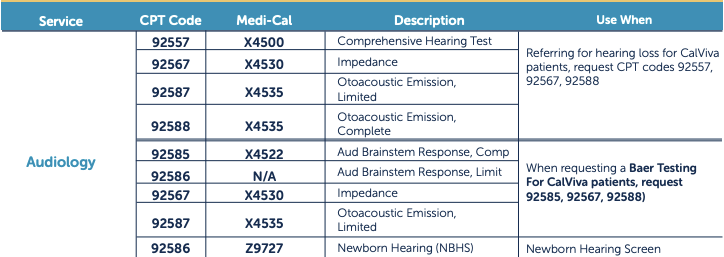

**We will create a pipeline to detect bodyparts and imaging tests entities and their relations. Then we will use these related chunks in CPT resolver model to get their CPT code.**

In [ ]:
document_assembler = DocumentAssembler()\
      .setInputCol("text")\
      .setOutputCol("document")

sentenceDetectorDL = SentenceDetectorDLModel.pretrained("sentence_detector_dl_healthcare", "en", 'clinical/models') \
      .setInputCols(["document"]) \
      .setOutputCol("sentence")

tokenizer = Tokenizer()\
      .setInputCols(["sentence"])\
      .setOutputCol("token")

word_embeddings = WordEmbeddingsModel.pretrained("embeddings_clinical", "en", "clinical/models")\
  .setInputCols(["sentence", "token"])\
  .setOutputCol("word_embeddings")


pos_tagger = PerceptronModel()\
    .pretrained("pos_clinical", "en", "clinical/models") \
    .setInputCols(["sentence", "token"])\
    .setOutputCol("pos_tags")
    
dependency_parser = DependencyParserModel()\
    .pretrained("dependency_conllu", "en")\
    .setInputCols(["sentence", "pos_tags", "token"])\
    .setOutputCol("dependencies")

# Named Entity Recognition for radiology reports.
clinical_ner = MedicalNerModel.pretrained("jsl_rd_ner_wip_greedy_clinical", "en", "clinical/models") \
   .setInputCols(["sentence", "token", "word_embeddings"]) \
   .setOutputCol("ner")

ner_chunker = NerConverter()\
    .setInputCols(["sentence", "token", "ner"])\
    .setOutputCol("ner_chunk")

re_model = RelationExtractionModel()\
    .pretrained("re_bodypart_directions", "en", 'clinical/models')\
    .setInputCols(["word_embeddings", "pos_tags", "ner_chunk", "dependencies"])\
    .setOutputCol("relations")\
    .setRelationPairs(["imagingtest-bodypart", "bodypart-imagingtest"])\
    .setMaxSyntacticDistance(4)\
    .setPredictionThreshold(0.5)
      

# Build up the pipeline
relation_pipeline = Pipeline(
    stages = [
        document_assembler,
        sentenceDetectorDL,
        tokenizer,
        word_embeddings,
        pos_tagger,
        dependency_parser,
        clinical_ner,
        ner_chunker,
        re_model
        ])


empty_data = spark.createDataFrame([['']]).toDF("text")

rel_model = relation_pipeline.fit(empty_data)

sentence_detector_dl_healthcare download started this may take some time.
Approximate size to download 367.3 KB
[OK!]
embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]
pos_clinical download started this may take some time.
Approximate size to download 1.5 MB
[OK!]
dependency_conllu download started this may take some time.
Approximate size to download 16.7 MB
[OK!]
jsl_rd_ner_wip_greedy_clinical download started this may take some time.
Approximate size to download 14.6 MB
[OK!]
re_bodypart_directions download started this may take some time.
Approximate size to download 9.2 MB
[OK!]


In [ ]:
light_rel_model = LightPipeline(rel_model)

In [ ]:
def get_relations_df (results, col='relations'):
    rel_pairs=[]
    for rel in results[0][col]:
        rel_pairs.append(( 
          rel.metadata['entity1'], 
          rel.metadata['entity1_begin'],
          rel.metadata['entity1_end'],
          rel.metadata['chunk1'], 
          rel.metadata['entity2'],
          rel.metadata['entity2_begin'],
          rel.metadata['entity2_end'],
          rel.metadata['chunk2'], 
          rel.metadata['confidence']
        ))

    rel_df = pd.DataFrame(rel_pairs, columns=['entity1','entity1_begin','entity1_end','chunk1',
                                              'entity2','entity2_end','entity2_end','chunk2', 
                                              'confidence'])
    
    # limit df columns to get entity and chunks with results only
    rel_df = rel_df.iloc[:,[0,3,4,7,8]]
    
    return rel_df

In [ ]:
text="Left shin pain. I have ordered x-ray of the left fibula and knee today. The patient will return to the clinic in 3 weeks. He is to call me in the interim for any problems."
light_result = light_rel_model.fullAnnotate(text)

get_relations_df(light_result)

,entity1,chunk1,entity2,chunk2,confidence
0,ImagingTest,x-ray,BodyPart,fibula,1.0
1,ImagingTest,x-ray,BodyPart,knee,0.9458425


**Now we can use get CPT codes of these related chunks.**

In [ ]:
documentAssembler = DocumentAssembler()\
      .setInputCol("text")\
      .setOutputCol("ner_chunk")

sbert_embedder = BertSentenceEmbeddings\
      .pretrained('sbiobert_base_cased_mli', 'en','clinical/models')\
      .setInputCols(["ner_chunk"])\
      .setOutputCol("sentence_embeddings")
    
cpt_resolver = SentenceEntityResolverModel.pretrained("sbiobertresolve_cpt_augmented","en", "clinical/models") \
      .setInputCols(["ner_chunk", "sentence_embeddings"]) \
      .setOutputCol("cpt_code")\
      .setDistanceFunction("EUCLIDEAN")


cpt_pipelineModel = PipelineModel(
    stages = [
        documentAssembler,
        sbert_embedder,
        cpt_resolver])


cpt_lp = LightPipeline(cpt_pipelineModel)

sbiobert_base_cased_mli download started this may take some time.
Approximate size to download 384.3 MB
[OK!]
sbiobertresolve_cpt_augmented download started this may take some time.
Approximate size to download 137.6 MB
[OK!]


In [ ]:
text = 'fibula x-ray'

%time get_codes (cpt_lp, text, vocab='cpt_code')

CPU times: user 14.9 ms, sys: 773 µs, total: 15.7 ms
Wall time: 188 ms


,chunks,begin,end,code,all_codes,resolutions,all_distances
0,fibula x-ray,0,11,73590,"[73590, 27676, 27455, 27712, 27457, 27707, 73550, 73090, 27635]","[Tibia and fibula X-ray, Incision of fibula, Incision of fibula, Incision of fibula, Incision of fibula, Incision of fibula, Femur X-ray (procedure), Forearm X-ray, Excision of lesion of fibula (procedure)]","[0.0895, 0.0970, 0.0970, 0.0970, 0.0970, 0.0970, 0.1360, 0.1364, 0.1474]"


In [ ]:
text = 'knee x-ray'

%time get_codes (cpt_lp, text, vocab='cpt_code')

CPU times: user 16.9 ms, sys: 3.02 ms, total: 19.9 ms
Wall time: 154 ms


,chunks,begin,end,code,all_codes,resolutions,all_distances
0,knee x-ray,0,9,73564,"[73564, 73562, 73580, 27486, 1010487, 27540, 27332, 27310, 27334, 27335, 27330, 73600, 73610, 1005006, 27447, 27446]","[Knee X-ray, Knee X-ray, Knee arthrogram, Knee joint operations, Radiologic examination, knee, Operative procedure on knee, Arthrotomy of knee (procedure), Arthrotomy of knee (procedure), Arthrotomy of knee (procedure), Arthrotomy of knee (procedure), Arthrotomy of knee (procedure), Ankle X-ray, Ankle X-ray, Arthrotomy, knee, Knee replacement, Knee replacement]","[0.0000, 0.0000, 0.0907, 0.1096, 0.1171, 0.1309, 0.1472, 0.1472, 0.1472, 0.1472, 0.1472, 0.1483, 0.1483, 0.1538, 0.1527, 0.1527]"


In [ ]:
text="TECHNIQUE IN DETAIL: After informed consent was obtained from the patient and his mother, the chest was scanned with portable ultrasound."
light_result = light_rel_model.fullAnnotate(text)

get_relations_df(light_result)

,entity1,chunk1,entity2,chunk2,confidence
0,BodyPart,chest,ImagingTest,portable ultrasound,0.9999802


In [ ]:
text = 'chest portable ultrasound'

%time get_codes (cpt_lp, text, vocab='cpt_code')

CPU times: user 9.7 ms, sys: 4.56 ms, total: 14.3 ms
Wall time: 147 ms


,chunks,begin,end,code,all_codes,resolutions,all_distances
0,chest portable ultrasound,0,24,1010771,"[1010771, 76512, 76510, 3320F, 76977, 76999, 76377, 45391, 76881, 31620, 3319F, 76882]","[Diagnostic Ultrasound Procedures of the Chest, A scan ultrasound, A scan ultrasound, USS - Ultrasound scan, USS - Ultrasound scan, USS - Ultrasound scan, USS - Ultrasound scan, USS - Ultrasound scan, USS - Ultrasound scan, USS - Ultrasound scan, USS - Ultrasound scan, USS - Ultrasound scan]","[0.1269, 0.1563, 0.1563, 0.1582, 0.1582, 0.1582, 0.1582, 0.1582, 0.1582, 0.1582, 0.1582, 0.1582]"


In [ ]:
text="This 73 y/o patient had Brain CT on 1/12/95, with progressive memory and cognitive decline since 8/11/94."
light_result = light_rel_model.fullAnnotate(text)

get_relations_df(light_result)

,entity1,chunk1,entity2,chunk2,confidence
0,BodyPart,Brain,ImagingTest,CT,0.9999999


In [ ]:
text = 'brain CT'

%time get_codes (cpt_lp, text, vocab='cpt_code')

CPU times: user 18.3 ms, sys: 523 µs, total: 18.8 ms
Wall time: 180 ms


,chunks,begin,end,code,all_codes,resolutions,all_distances
0,brain CT,0,7,78607,"[78607, 1010296, 76497, 3319F, 70498, 62284, 72127]","[Cerebral scan, Computed tomography, head or brain, Computerized tomography, Computerized tomography, Computerized tomography, Computed tomography of spine, Computed tomography of cervical spine]","[0.1265, 0.1371, 0.1414, 0.1414, 0.1414, 0.1470, 0.1599]"


## Sentence Entity Resolver (SNOMED)

SNOMED CT is one of a suite of designated standards for use in U.S. Federal Government systems for the electronic exchange of clinical health information and is also a required standard in interoperability specifications of the U.S. Healthcare Information Technology Standards Panel. The clinical terminology is owned and maintained by SNOMED International, a not-for-profit association. 

SNOMED CT:

- Is the most comprehensive and precise, multilingual health terminology in the world.
- Has been, and continues to be, developed collaboratively to ensure it meets the diverse needs and expectations of the worldwide medical profession.
- Assists with the electronic exchange of clinical health information.
- Can be mapped to other coding systems, such as ICD-9 and ICD-10, which helps facilitate semantic interoperability.
- Is accepted as a common global language for health terms in over 50 countries.
- Is a resource with extensive, scientifically validated clinical content

In [ ]:
documentAssembler = DocumentAssembler()\
      .setInputCol("text")\
      .setOutputCol("ner_chunk")

sbert_embedder = BertSentenceEmbeddings\
      .pretrained('sbiobert_base_cased_mli', 'en','clinical/models')\
      .setInputCols(["ner_chunk"])\
      .setOutputCol("sentence_embeddings")
    
snomed_ct_resolver = SentenceEntityResolverModel.pretrained("sbiobertresolve_snomed_findings","en", "clinical/models") \
      .setInputCols(["ner_chunk", "sentence_embeddings"]) \
      .setOutputCol("snomed_code")\
      .setDistanceFunction("EUCLIDEAN")

snomed_pipelineModel = PipelineModel(
    stages = [
        documentAssembler,
        sbert_embedder,
        snomed_ct_resolver])

snomed_lp = LightPipeline(snomed_pipelineModel)


sbiobert_base_cased_mli download started this may take some time.
Approximate size to download 384.3 MB
[OK!]
sbiobertresolve_snomed_findings download started this may take some time.
Approximate size to download 1.3 GB
[OK!]


In [ ]:
text = 'bladder cancer'

%time get_codes (snomed_lp, text, vocab='snomed_code')

CPU times: user 9.41 ms, sys: 9.9 ms, total: 19.3 ms
Wall time: 948 ms


,chunks,begin,end,code,all_codes,resolutions,all_distances
0,bladder cancer,0,13,399326009,"[399326009, 363455001, 425066001, 255108000, 269607003, 154540000, 425231005, 255110003, 393562002, 255109008, 255111004, 92546004, 254932004]","[bladder cancer, bladder cancer, invasive bladder cancer, carcinoma of bladder, carcinoma of bladder, carcinoma of bladder, superficial bladder cancer, adenocarcinoma of bladder, transitional cell carcinoma of bladder, transitional cell carcinoma of bladder, squamous cell carcinoma of bladder, cancer in situ of urinary bladder, tumor of bladder neck]","[0.0000, 0.0000, 0.0539, 0.0666, 0.0666, 0.0666, 0.0809, 0.0881, 0.0880, 0.0880, 0.0913, 0.0978, 0.1080]"


In [ ]:
text = 'atrial fibrillation'

%time get_codes (snomed_lp, text, vocab='snomed_code')

CPU times: user 11.4 ms, sys: 5.11 ms, total: 16.5 ms
Wall time: 764 ms


,chunks,begin,end,code,all_codes,resolutions,all_distances
0,atrial fibrillation,0,18,49436004,"[49436004, 155364009, 266306001, 282825002, 440059007, 426749004, 195081002, 762247006, 164889003, 300996004, 142049000, 440028005, 195080001, 81216002]","[atrial fibrillation, atrial fibrillation, atrial fibrillation, intermittent atrial fibrillation, persistent atrial fibrillation, chronic atrial fibrillation, paroxysmal atrial fibrillation, preexcited atrial fibrillation, electrocardiographic atrial fibrillation, controlled atrial fibrillation (disorder), ecg: atrial fibrillation, permanent atrial fibrillation (disorder), atrial fibrillation and flutter, atrial fibrillation and flutter]","[0.0000, 0.0000, 0.0000, 0.0185, 0.0220, 0.0265, 0.0273, 0.0356, 0.0395, 0.0479, 0.0498, 0.0533, 0.0532, 0.0532]"


## Sentence Entity Resolver (LOINC)

Logical Observation Identifiers Names and Codes (LOINC) is a database and universal standard for identifying medical laboratory observations. First developed in 1994, it was created and is maintained by the Regenstrief Institute, a US nonprofit medical research organization. LOINC was created in response to the demand for an electronic database for clinical care and management and is publicly available at no cost.

It is endorsed by the American Clinical Laboratory Association. Since its inception, the database has expanded to include not just medical laboratory code names but also nursing diagnosis, nursing interventions, outcomes classification, and patient care data sets.

LOINC applies universal code names and identifiers to medical terminology related to electronic health records. The purpose is to assist in the electronic exchange and gathering of clinical results (such as laboratory tests, clinical observations, outcomes management and research). LOINC has two main parts: laboratory LOINC and clinical LOINC.

In [ ]:
documentAssembler = DocumentAssembler()\
      .setInputCol("text")\
      .setOutputCol("ner_chunk")

sbert_embedder = BertSentenceEmbeddings\
      .pretrained('sbiobert_base_cased_mli', 'en','clinical/models')\
      .setInputCols(["ner_chunk"])\
      .setOutputCol("sentence_embeddings")
    
loinc_resolver = SentenceEntityResolverModel.pretrained("sbiobertresolve_loinc", "en", "clinical/models") \
      .setInputCols(["ner_chunk", "sentence_embeddings"]) \
      .setOutputCol("loinc_code")\
      .setDistanceFunction("EUCLIDEAN")

loinc_pipelineModel = PipelineModel(
    stages = [
        documentAssembler,
        sbert_embedder,
        loinc_resolver])

loinc_lp = LightPipeline(loinc_pipelineModel)

sbiobert_base_cased_mli download started this may take some time.
Approximate size to download 384.3 MB
[OK!]
sbiobertresolve_loinc download started this may take some time.
Approximate size to download 212.6 MB
[OK!]


In [ ]:
text = 'FLT3 gene mutation analysis'

%time get_codes (loinc_lp, text, vocab='loinc_code')

CPU times: user 8.18 ms, sys: 7 ms, total: 15.2 ms
Wall time: 198 ms


,chunks,begin,end,code,all_codes,resolutions,all_distances
0,FLT3 gene mutation analysis,0,26,54447-8,"[54447-8, 47958-4, 53840-5, 21676-2, 75391-3, 38413-1, 58987-9, 49704-0, 46225-9, 82517-4, 53895-9, 21740-6, 34499-4, 41098-5, 49873-3, 71358-6, 47974-1, 40427-7, 41108-2, 81831-0, 22074-9, 35291-4, 38532-8, 59045-5, 41753-5]","[FLT3 gene targeted mutation analysis, FLT3 gene targeted mutation analysis, TGFB3 gene targeted mutation analysis, FGFR3 gene targeted mutation analysis, FGFR3 gene targeted mutation analysis, FGFR3 gene targeted mutation analysis, ITGB3 gene targeted mutation analysis, SH3TC2 gene targeted mutation analysis, ABCA3 gene targeted mutation analysis, LAMA3 gene targeted mutation analysis, SH3BP2 gene targeted mutation analysis, TRAF3 gene targeted mutation analysis, GPC3 gene targeted mutation analysis, GPC3 gene targeted mutation analysis, POU3F4 gene targeted mutation analysis, GJB3 gene targeted mutation analysis, THRB gene targeted mutation analysis, FGF23 gene targeted mutation analysis, FGF23 gene targeted mutation analysis, LAMB3 gene targeted mutation analysis, FGFR3 gene mutations tested for, UBE3A gene targeted mutation analysis, SPG3A gene targeted mutation analysis, ITGB3 gene mutations tested for, FKRP gene targeted mutation analysis]","[0.1369, 0.1369, 0.1516, 0.1571, 0.1571, 0.1571, 0.1594, 0.1641, 0.1635, 0.1635, 0.1692, 0.1651, 0.1701, 0.1701, 0.1716, 0.1739, 0.1719, 0.1797, 0.1797, 0.1771, 0.1810, 0.1744, 0.1803, 0.1845, 0.1804]"


In [ ]:
text = 'Hematocrit'

%time get_codes (loinc_lp, text, vocab='loinc_code')

CPU times: user 18.5 ms, sys: 1.85 ms, total: 20.4 ms
Wall time: 196 ms


,chunks,begin,end,code,all_codes,resolutions,all_distances
0,Hematocrit,0,9,11151-8,"[11151-8, 42908-4, 11271-4, 30398-2, 48703-3, 13508-7, 71828-8, 55781-9, 17809-5, 4545-0, 71829-6, 47640-8, 71830-4, 11153-4, 31100-1, 4544-3, 71831-2, 70168-0, 32354-3, 62241-5, 70169-8, 71833-8, 20570-8, 41654-5, 41655-2]","[Hematocrit, Hematocrit, Hematocrit, Hematocrit, Hematocrit, Hematocrit, Hematocrit, Hematocrit, Hematocrit, Hematocrit, Hematocrit, Hematocrit, Hematocrit, Hematocrit, Hematocrit, Hematocrit, Hematocrit, Hematocrit, Hematocrit, Hematocrit, Hematocrit, Hematocrit, Hematocrit, Hematocrit, Hematocrit]","[0.0732, 0.0732, 0.0732, 0.0732, 0.0732, 0.0732, 0.0732, 0.0732, 0.0732, 0.0732, 0.0732, 0.0732, 0.0732, 0.0732, 0.0732, 0.0732, 0.0732, 0.0732, 0.0732, 0.0732, 0.0732, 0.0732, 0.0732, 0.0732, 0.0732]"


## Sentence Entity Resolver (UMLS)

Unified Medical Language System (UMLS) integrates and distributes key terminology, classification and coding standards, and associated resources to promote creation of more effective and interoperable biomedical information systems and services, including electronic health records.

The UMLS, or Unified Medical Language System, is a set of files and software that brings together many health and biomedical vocabularies and standards to enable interoperability between computer systems.

The Metathesaurus forms the base of the UMLS and comprises over 1 million biomedical concepts and 5 million concept names, all of which stem from the over 100 incorporated controlled vocabularies and classification systems. Some examples of the incorporated controlled vocabularies are CPT, ICD-10, MeSH, SNOMED CT, DSM-IV, LOINC, WHO Adverse Drug Reaction Terminology, UK Clinical Terms, RxNorm, Gene Ontology, and OMIM

In [ ]:
documentAssembler = DocumentAssembler()\
      .setInputCol("text")\
      .setOutputCol("ner_chunk")

sbert_embedder = BertSentenceEmbeddings\
      .pretrained('sbiobert_base_cased_mli', 'en','clinical/models')\
      .setInputCols(["ner_chunk"])\
      .setOutputCol("sentence_embeddings")
    
umls_resolver = SentenceEntityResolverModel.pretrained("sbiobertresolve_umls_major_concepts", "en", "clinical/models") \
      .setInputCols(["ner_chunk", "sentence_embeddings"]) \
      .setOutputCol("umls_code")\
      .setDistanceFunction("EUCLIDEAN")

umls_pipelineModel = PipelineModel(
    stages = [
        documentAssembler,
        sbert_embedder,
        umls_resolver])

umls_lp = LightPipeline(umls_pipelineModel)

sbiobert_base_cased_mli download started this may take some time.
Approximate size to download 384.3 MB
[OK!]
sbiobertresolve_umls_major_concepts download started this may take some time.
Approximate size to download 817.3 MB
[OK!]


In [ ]:
# Injuries & poisoning
text = 'food poisoning'

%time get_codes (umls_lp, text, vocab='umls_code')

CPU times: user 11.6 ms, sys: 3.9 ms, total: 15.5 ms
Wall time: 467 ms


,chunks,begin,end,code,all_codes,resolutions,all_distances
0,food poisoning,0,13,C0016479,"[C0016479, C0349783, C0411266, C0178496, C0161615, C0275107, C1272775, C0161721, C0232071, C0749596, C1271087, C0274909, C0679360]","[food poisoning, infectious food poisoning, chemical food poisoning (disorder), food poisoning bacterial, digestant poisoning, poisoning caused by ingestion of insect-infested food (disorder), burns food, toxic effect of noxious substance eaten as food (disorder), food aspiration, ingestion poisoning, suspected food poisoning (situation), toxic effect of food contaminant (disorder), foodborne illness]","[0.0000, 0.0507, 0.0660, 0.0668, 0.0871, 0.0876, 0.0913, 0.0981, 0.0989, 0.1006, 0.1033, 0.1042, 0.1041]"


In [ ]:
# clinical findings
text = 'type two diabetes mellitus'

%time get_codes (umls_lp, text, vocab='umls_code')

CPU times: user 7.12 ms, sys: 7.57 ms, total: 14.7 ms
Wall time: 487 ms


,chunks,begin,end,code,all_codes,resolutions,all_distances
0,type two diabetes mellitus,0,25,C4014362,"[C4014362, C3532488, C1320657, C1313937, C0455488, C2733146, C4017629, C3532489, C4538688, C3275844, C0241863, C3280267, C1261139, C0421248, C5195213, C1317301, C3278636, C2675471, C3280359]","[type 2 diabetes mellitus (t2d), history of diabetes mellitus type 2 (situation), diabete type, fh: diabetes mellitus, pre-existing diabetes mellitus, type 2 diabetes mellitus uncontrolled, diabetes mellitus, type ii, digenic, history of diabetes mellitus type i, diabetes mellitus, type 2 (in some heterozygous adults), diabetes mellitus, type ii, susceptibility to, diabetic, type 2 diabetes (in some), diabetic relative, insulin diabetic, increased risk of type 2 diabetes, diabetes status, neonatal insulin-dependent diabetes mellitus, microvascular complications of diabetes, susceptibility to, 2, diabetes mellitus (in some patients)]","[0.0438, 0.0568, 0.0618, 0.0697, 0.0780, 0.0891, 0.0910, 0.0883, 0.0937, 0.0940, 0.0939, 0.0971, 0.1031, 0.1062, 0.1087, 0.1104, 0.1116, 0.1201, 0.1147]"


## Sentence Entity Resolver (HPO)

The Human Phenotype Ontology (HPO) is a formal ontology of human phenotypes. Developed in collaboration with members of the Open Biomedical Ontologies Foundry, HPO currently contains over 13,000 terms and over 156,000 annotations to hereditary diseases. Data from Online Mendelian Inheritance in Man and medical literature were used to generate the terms currently in the HPO. The ontology contains over 50,000 annotations between phenotypes and hereditary disease.

Each term in the HPO describes a clinical abnormality. These may be general terms, such as Abnormal ear morphology or very specific ones such as Chorioretinal atrophy. Each term is also assigned to one of the five subontologies. The terms have a unique ID such as HP:0001140 and a label such as *Epibulbar dermoid*.

In [ ]:
documentAssembler = DocumentAssembler()\
      .setInputCol("text")\
      .setOutputCol("ner_chunk")

sbert_embedder = BertSentenceEmbeddings\
      .pretrained('sbiobert_base_cased_mli', 'en','clinical/models')\
      .setInputCols(["ner_chunk"])\
      .setOutputCol("sentence_embeddings")
    
hpo_resolver = SentenceEntityResolverModel.pretrained("sbiobertresolve_HPO", "en", "clinical/models") \
      .setInputCols(["ner_chunk", "sentence_embeddings"]) \
      .setOutputCol("umls_code")\
      .setDistanceFunction("EUCLIDEAN")

hpo_pipelineModel = PipelineModel(
    stages = [
        documentAssembler,
        sbert_embedder,
        hpo_resolver])

hpo_lp = LightPipeline(hpo_pipelineModel)

sbiobert_base_cased_mli download started this may take some time.
Approximate size to download 384.3 MB
[OK!]
sbiobertresolve_HPO download started this may take some time.
Approximate size to download 97.9 MB
[OK!]


In [ ]:
text = 'schizophrenia '

%time get_codes (hpo_lp, text, vocab='umls_code')

CPU times: user 15.5 ms, sys: 5.11 ms, total: 20.6 ms
Wall time: 131 ms


,chunks,begin,end,code,all_codes,resolutions,all_distances
0,schizophrenia,0,13,HP:0100753,"[HP:0100753, HP:0000709, HP:0007302, HP:0000708, HP:0000725, HP:0011511, HP:0012077, HP:0001345, HP:0030325, HP:0012075, HP:0000722, HP:0033512, HP:0012076, HP:0100923, HP:0002072, HP:0033715, HP:0010891, HP:0011626, HP:0100656, HP:0033516, HP:0008404, HP:0002269]","[schizophrenia, psychosis, bipolar disorder, psychiatric disorders, psychotic episodes, macular schisis, histrionic personality disorder, psychotic mentation, cervicomedullary schisis, personality disorder, obsessive compulsive disorder, stimulant dependence, borderline personality disorder, clavicular sclerosis, choreatic disease, mesial temporal sclerosis, scheuermann disease, scimitar syndrome, thoracoabdominal schisis, benzodiazepine dependence, onychodystrophy, migrational brain disorder]","[0.0000, 0.1172, 0.1488, 0.1599, 0.1877, 0.1898, 0.1923, 0.2033, 0.2163, 0.2113, 0.2166, 0.2257, 0.2202, 0.2345, 0.2431, 0.2389, 0.2497, 0.2438, 0.2578, 0.2483, 0.2604, 0.2455]"


In [ ]:
text = 'Abnormality of the upper limb'

%time get_codes (hpo_lp, text, vocab='umls_code')

CPU times: user 9.82 ms, sys: 4.64 ms, total: 14.5 ms
Wall time: 144 ms


,chunks,begin,end,code,all_codes,resolutions,all_distances
0,Abnormality of the upper limb,0,28,HP:0002817,"[HP:0002817, HP:0009810, HP:0001454, HP:0100560, HP:0009808, HP:0001446, HP:0001457, HP:0040064, HP:0040286, HP:0000177, HP:0002813, HP:0100022, HP:0002087, HP:0010755, HP:0009127, HP:0011729, HP:0001999, HP:0000271, HP:0000496]","[abnormality of the upper limb, abnormality of upper limb joint, abnormality of the upper arm, upper limb asymmetry, diaphyseal abnormality of the upper limbs, abnormal upper limb muscles, abnormality of the musculature of the upper arm, abnormality of limbs, abnormality of axial muscles, abnormality of upper lip, limb abnormality, abnormality of movement, abnormality of the upper respiratory tract, asymmetry of upper jaw, abnormal limb muscles, abnormality of joint mobility, abnormal facial shape, facial abnormality, abnormal eye movement]","[0.0203, 0.0353, 0.0353, 0.0541, 0.0645, 0.0644, 0.0719, 0.0756, 0.0789, 0.0830, 0.0829, 0.0827, 0.0860, 0.0881, 0.0889, 0.0899, 0.0901, 0.0900, 0.0911]"


In [ ]:
text = 'Muscle haemorrhage'

%time get_codes (hpo_lp, text, vocab='umls_code')

CPU times: user 8.85 ms, sys: 5.94 ms, total: 14.8 ms
Wall time: 134 ms


,chunks,begin,end,code,all_codes,resolutions,all_distances
0,Muscle haemorrhage,0,17,HP:0040242,"[HP:0040242, HP:0012233, HP:0025582, HP:0031611, HP:0011029, HP:0009045, HP:0003201, HP:0031803, HP:0002138, HP:0011440, HP:0001933, HP:0025239, HP:0040223, HP:0005261, HP:0031805, HP:0002239]","[muscle haemorrhage, intramuscular hemorrhage, submacular haemorrhage, sub-ilm haemorrhage, internal haemorrhage, exercise-induced rhabdomyolysis, rhabdomyolysis, fundus haemorrhage, subarachnoid haemorrhage, alcohol-induced rhabdomyolysis, subcutaneous haemorrhage, subhyaloid haemorrhage, pulmonary haemorrhage, joint haemorrhage, intraretinal haemorrhage, gi hemorrhage]","[0.0516, 0.0939, 0.1355, 0.1515, 0.1608, 0.1641, 0.1653, 0.1648, 0.1670, 0.1696, 0.1671, 0.1755, 0.1691, 0.1726, 0.1712, 0.1775]"


## Router - Using Resolver Models Together

Normally, when we need to use more than one sentence entity resolver models in the same pipeline, we used to hit `BertSentenceEmbeddings` annotator more than once given the number of different resolver models in the same pipeline. Now we are introducing a solution with the help of `Router` annotator that could allow us to feed all the NER chunks to `BertSentenceEmbeddings` at once and then route the output of Sentence Embeddings to different resolver models needed.

In this example, lets use `sbiobertresolve_rxnorm` RxNorm model and `sbiobertresolve_icd10cm_slim_billable_hcc` ICD10CM-HCC models together. First we will get the `PROBLEM` entities form `ner_clinical` model and then get the `DRUG` entities from `ner_posology` model. Then we will merge them and use the `Chunk2Doc` annotator to create sentence chunks to populate Sentence Embeddings column. Then, we route the embeddings of `PROBLEM` entities to ICD10CM model and embeddings of `DRUG` entities to RxNorm model at the same time.

In [ ]:
documentAssembler = DocumentAssembler()\
        .setInputCol("text")\
        .setOutputCol("document")

sentenceDetector = SentenceDetector()\
        .setInputCols("document")\
        .setOutputCol("sentence")

tokenizer = Tokenizer()\
        .setInputCols("sentence")\
        .setOutputCol("token")

word_embeddings = WordEmbeddingsModel.pretrained("embeddings_clinical", "en", "clinical/models")\
        .setInputCols("sentence", "token")\
        .setOutputCol("word_embeddings")

# to get PROBLEM entitis
clinical_ner = MedicalNerModel().pretrained("ner_clinical", "en", "clinical/models") \
        .setInputCols(["sentence", "token", "word_embeddings"]) \
        .setOutputCol("clinical_ner")

clinical_ner_chunk = NerConverter()\
        .setInputCols("sentence","token","clinical_ner")\
        .setOutputCol("clinical_ner_chunk")\
        .setWhiteList(["PROBLEM"])

# to get DRUG entities 
posology_ner = MedicalNerModel().pretrained("ner_posology", "en", "clinical/models") \
        .setInputCols(["sentence", "token", "word_embeddings"]) \
        .setOutputCol("posology_ner")

posology_ner_chunk = NerConverter()\
        .setInputCols("sentence","token","posology_ner")\
        .setOutputCol("posology_ner_chunk")\
        .setWhiteList(["DRUG"])

# merge the chunks into a single ner_chunk
chunk_merger = ChunkMergeApproach()\
        .setInputCols("clinical_ner_chunk","posology_ner_chunk")\
        .setOutputCol("final_ner_chunk")\
        .setMergeOverlapping(False)


# convert chunks to doc to get sentence embeddings of them
chunk2doc = Chunk2Doc().setInputCols("final_ner_chunk").setOutputCol("final_chunk_doc")


sbiobert_embeddings = BertSentenceEmbeddings.pretrained("sbiobert_base_cased_mli","en","clinical/models")\
        .setInputCols(["final_chunk_doc"])\
        .setOutputCol("sbert_embeddings")

# filter PROBLEM entity embeddings
router_sentence_icd10 = Router() \
        .setInputCols("sbert_embeddings") \
        .setFilterFieldsElements(["PROBLEM"]) \
        .setOutputCol("problem_embeddings")

# filter DRUG entity embeddings
router_sentence_rxnorm = Router() \
        .setInputCols("sbert_embeddings") \
        .setFilterFieldsElements(["DRUG"]) \
        .setOutputCol("drug_embeddings")

# use problem_embeddings only
icd_resolver = SentenceEntityResolverModel.pretrained("sbiobertresolve_icd10cm_slim_billable_hcc","en", "clinical/models") \
        .setInputCols(["clinical_ner_chunk", "problem_embeddings"]) \
        .setOutputCol("icd10cm_code")\
        .setDistanceFunction("EUCLIDEAN")


# use drug_embeddings only
rxnorm_resolver = SentenceEntityResolverModel.pretrained("sbiobertresolve_rxnorm","en", "clinical/models") \
        .setInputCols(["posology_ner_chunk", "drug_embeddings"]) \
        .setOutputCol("rxnorm_code")\
        .setDistanceFunction("EUCLIDEAN")


pipeline = Pipeline(stages=[
    documentAssembler,
    sentenceDetector,
    tokenizer,
    word_embeddings,
    clinical_ner,
    clinical_ner_chunk,
    posology_ner,
    posology_ner_chunk,
    chunk_merger,
    chunk2doc,
    sbiobert_embeddings,
    router_sentence_icd10,
    router_sentence_rxnorm,
    icd_resolver,
    rxnorm_resolver
])

empty_data = spark.createDataFrame([['']]).toDF("text")
model = pipeline.fit(empty_data)

embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]
ner_clinical download started this may take some time.
Approximate size to download 13.9 MB
[OK!]
ner_posology download started this may take some time.
Approximate size to download 13.8 MB
[OK!]
sbiobert_base_cased_mli download started this may take some time.
Approximate size to download 384.3 MB
[OK!]
sbiobertresolve_icd10cm_slim_billable_hcc download started this may take some time.
Approximate size to download 856.5 MB
[OK!]
sbiobertresolve_rxnorm download started this may take some time.
Approximate size to download 802.6 MB
[OK!]


In [ ]:
print(clinical_note)

A 28-year-old female with a history of gestational diabetes mellitus diagnosed eight years prior to presentation and subsequent type two diabetes mellitus (T2DM), one prior episode of HTG-induced pancreatitis three years prior to presentation, associated with an acute hepatitis, and obesity with a body mass index (BMI) of 33.5 kg/m2, presented with a one-week history of polyuria, polydipsia, poor appetite, and vomiting. Two weeks prior to presentation, she was treated with a five-day course of amoxicillin for a respiratory tract infection. She was on metformin, glipizide, and dapagliflozin for T2DM and atorvastatin and gemfibrozil for HTG. She had been on dapagliflozin for six months at the time of presentation. Physical examination on presentation was significant for dry oral mucosa; significantly, her abdominal examination was benign with no tenderness, guarding, or rigidity. Pertinent laboratory findings on admission were: serum glucose 111 mg/dl, bicarbonate 18 mmol/l, anion gap 20

In [ ]:
df = spark.createDataFrame([[clinical_note]]).toDF("text")

result = model.transform(df)

In [ ]:
icd10_result = get_codes_from_df(result, 'clinical_ner_chunk', 'icd10cm_code', hcc=True)

In [ ]:
# extract HCC informationinto different columns

icd10_result["billable"] = icd10_result["hcc_list"].apply(extract_billable).apply(pd.Series).iloc[:,0]    
icd10_result["hcc_status"] = icd10_result["hcc_list"].apply(extract_billable).apply(pd.Series).iloc[:,1]
icd10_result["hcc_score"] = icd10_result["hcc_list"].apply(extract_billable).apply(pd.Series).iloc[:,2]

icd10_result.drop("hcc_list", axis=1, inplace= True)

In [ ]:
icd10_result.head(15)

,sent_id,ner_chunk,entity,icd10_code,all_codes,resolutions,billable,hcc_status,hcc_score
0,0,gestational diabetes mellitus,PROBLEM,O24919,"[O24919, E119, O2441, O24419, O2443, O24439, Z8632, O24319, O2431, O2411, O244, P700, O241]","[gestational diabetes mellitus [Unspecified diabetes mellitus in pregnancy, unspecified trimester], gestational diabetes mellitus [Type 2 diabetes mellitus without complications], gestational diabetes mellitus [Gestational diabetes mellitus in pregnancy], gestational diabetes mellitus in pregnancy [Gestational diabetes mellitus in pregnancy, unspecified control], postpartum gestational diabetes mellitus [Gestational diabetes mellitus in the puerperium], postpartum gestational diabetes mellitus [Gestational diabetes mellitus in the puerperium, unspecified control], history of gestational diabetes mellitus [Personal history of gestational diabetes], preexisting diabetes mellitus in pregnancy [Unspecified pre-existing diabetes mellitus in pregnancy, unspecified trimester], pre-existing diabetes mellitus in pregnancy [Unspecified pre-existing diabetes mellitus in pregnancy], pre-existing diabetes mellitus in pregnancy (disorder) [Pre-existing type 2 diabetes mellitus, in pregnancy], postpartum gestational diabetes mellitus (disorder) [Gestational diabetes mellitus], newborn affected by maternal gestational diabetes mellitus [Syndrome of infant of mother with gestational diabetes], pre-existing type 2 diabetes mellitus in pregnancy [Pre-existing type 2 diabetes mellitus, in pregnancy, childbirth and the puerperium]]","[1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0]","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 19, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1,0,subsequent type two diabetes mellitus,PROBLEM,O2411,"[O2411, E118, E119, E11, E139, E113, E1144, E1143, E1151, E117, E115]","[pre-existing type 2 diabetes mellitus [Pre-existing type 2 diabetes mellitus, in pregnancy], disorder associated with type 2 diabetes mellitus [Type 2 diabetes mellitus with unspecified complications], type 2 diabetes mellitus [Type 2 diabetes mellitus without complications], type 2 diabetes mellitus [Type 2 diabetes mellitus], secondary diabetes mellitus [Other specified diabetes mellitus without complications], disorder of eye due to type 2 diabetes mellitus [Type 2 diabetes mellitus with ophthalmic complications], disorder of nervous system due to type 2 diabetes mellitus [Type 2 diabetes mellitus with diabetic amyotrophy], neurological disorder with type 2 diabetes mellitus [Type 2 diabetes mellitus with diabetic autonomic (poly)neuropathy], diabetes mellitus type 2 with complications [Type 2 diabetes mellitus with diabetic peripheral angiopathy without gangrene], multiple complications of type 2 diabetes mellitus [Type 2 diabetes mellitus], peripheral circulatory disorder due to type 2 diabetes mellitus [Type 2 diabetes mellitus with circulatory complications]]","[0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0]","[0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0]","[0, 18, 19, 0, 19, 0, 75/18, 75/18, 108/18, 0, 0]"
2,0,T2DM,PROBLEM,E11,"[E11, E119, E118, O2411, E139, E113, E148, E149, Z833, E138, E117, E114, Z794, E1169]","[type 2 diabetes mellitus [Type 2 diabetes mellitus], type 2 diabetes mellitus [Type 2 diabetes mellitus without complications], disorder associated with type 2 diabetes mellitus [Type 2 diabetes mellitus with unspecified complications], pre-existing type 2 diabetes mellitus [Pre-existing type 2 diabetes mellitus, in pregnancy], secondary diabetes mellitus [Other specified diabetes mellitus without complications], disorder of eye with type 2 diabetes mellitus [Type 2 diabetes mellitus with ophthalmic complications], disorder associated with diabetes mellitus, dm - diabetes mellitus, fh: diabetes mellitus [Family history of diabetes mellitus], secondary diabetes [Other specified diabetes mellitus with unspecified complications], multiple complications of type 2 diabetes mellitus [Type 2 diabetes mellitus], neurological disorder with diabetes type 

Now lets get RxNorm codes from our results.

In [ ]:
rxnorm_result = get_codes_from_df(result, 'posology_ner_chunk', 'rxnorm_code', hcc=False)

rxnorm_result.head(15)

,sent_id,ner_chunk,entity,icd10_code,all_codes,resolutions
0,1,amoxicillin,DRUG,723,"[723, 540141, 437527, 1152900, 370576, 1152901, 267360, 733, 756429, 1173522, 370578, 1152899, 2625, 3356, 1173523, 1153197, 1152898, 2108823, 637702, 1721470, 365850, 381196, 2582, 641, 370882]","[amoxicillin, amoxicillinan, amoxicillin syrup, amoxicillin oral product, amoxicillin oral suspension, amoxicillin pill, amoxicillin sodium, ampicillin, amoxicillin oral solution, amoxicillinan oral product, amoxicillin oral capsule, amoxicillin oral liquid product, cloxacillin, dicloxacillin, amoxicillinan pill, ampicillin oral product, amoxicillin injectable product, clavacillin, amoxicillin / ampicillin oral suspension, ampicillin injection, amoxicillin oral suspension [amoxil], amoxidin, clindamycin, amikacin, amoxicillin injectable solution]"
1,2,metformin,DRUG,6809,"[6809, 1161611, 152161, 1161610, 406082, 8129, 235743, 1161609, 1182890, 1182891, 372803, 29648, 152751, 406257, 227555, 50470, 29903, 1176937, 1525, 1156437, 29682, 4556, 6920, 29950, 6851]","[metformin, metformin pill, orabet metformin, metformin oral product, metformin oral solution, phenformin, metformin hydrochloride, metformin oral liquid product, orabet metformin oral product, orabet metformin pill, metformin oral tablet, methdilazine, methadose, metformin oral solution [riomet], methergine, gluceptate, methylparaben, methylin oral product, bezafibrate, phenformin pill, methixene, framycetin, metrizamide, metocurine, methotrexate]"
2,2,glipizide,DRUG,4821,"[4821, 1165207, 1165208, 4816, 25789, 4815, 372320, 1368001, 541895, 542064, 5033, 475968, 1551291, 1165203, 1047432, 227225, 1157244, 1433881, 2105845, 19729, 1156201, 1100699, 28382, 1862957, 25793]","[glipizide, glipizide oral product, glipizide pill, gliclazide, glimepiride, glyburide, glipizide oral tablet, alogliptin, glyguride, gyburide, guanabenz, liraglutide, dulaglutide, gliclazide oral product, gablofen, guanabenz acetate, glimepiride oral product, gallimycin, glasdegib, idrocilamide, glyburide pill, linagliptin, lacidipine, galliprant, gliquidone]"
3,2,dapagliflozin,DRUG,1488564,"[1488564, 1545653, 1992672, 1488566, 1488567, 1545655, 1992674, 1373458, 1488568, 1545656, 1992807, 1486966, 1925495, 1545657, 1992808, 136198, 485418, 1546356, 1169558, 3098, 73044, 1925496, 33738, 596554, 1169559]","[dapagliflozin, empagliflozin, ertugliflozin, dapagliflozin oral product, dapagliflozin pill, empagliflozin oral product, ertugliflozin pidolate, canagliflozin, dapagliflozin oral tablet, empagliflozin pill, ertugliflozin oral product, dapagliflozin propanediol, dapagliflozin / saxagliptin oral product, empagliflozin oral tablet, ertugliflozin pill, darifenacin, darifenacin, dabigatran, dazidox oral product, dacarbazine, repaglinide, dapagliflozin / saxagliptin pill, pioglitazone, vildagliptin, dazidox pill]"
4,2,atorvastatin,DRUG,83367,"[83367, 1158285, 1158284, 301542, 596723, 221072, 437783, 83366, 477287, 42463, 41127, 6472, 72875, 370621, 1157991, 1923505, 1161691, 36567, 203144, 1923506, 1157992, 1165660, 1152441, 1165346, 1153764]","[atorvastatin, atorvastatin pill, atorvastatin oral product, rosuvastatin, cerivastatin, cerivastatin sodium, atorvastatin oral capsule, atorvastatin calcium, atorvastatin calcium, pravastatin, fluvastatin, lovastatin, fluvastatin sodium, atorvastatin oral tablet, rosuvastatin oral product, cerivastatin oral product, pravastatin oral product, simvastatin, pravastatin sodium, cerivastatin pill, rosuvastatin pill, fluvastatin oral product, cerivastatin sodium oral product, lovastatin oral product, aspirin / pravastatin oral product]"
5,2,gemfibrozil,DRUG,4719,"[4719, 1163944, 1163945, 372299, 1722380, 138099, 2105823, 328134, 372300, 2056691, 1425222, 2260702, 402429, 1302966, 8703, 1525, 2044896, 236781, 1440046, 228476, 1494066, 1157229, 259315, 30202, 1312397]","[gemfibrozil, gemfibrozil oral product, gemfibrozil pill, gemfibrozil oral capsule, cobimetinib fumarate, gemifloxacin, gilter

### Using Router with Single NER Model

**If we want to get entities from only ONE NER model, it will be sufficient to feed the resolver models only with sentence embeddings from the `Router`. In the example below, we use `ner_jsl` model to get the `Disease_Syndrome_Disorder`,`Oncological`, `Symptom`, `Drug` entities. Then we will feed the ICD10CM resolver model with the sentence embeddings of `Disease_Syndrome_Disorder`,`Oncological`, `Symptom` entities (`problem_embeddings`), and RxNorm resolver with `Drug` entities (`drug_embeddings`) from the `Router`.**

In [ ]:
jsl_ner = MedicalNerModel().pretrained("ner_jsl_slim", "en", "clinical/models") \
        .setInputCols(["sentence", "token", "word_embeddings"]) \
        .setOutputCol("ner")

jsl_chunk = NerConverter()\
        .setInputCols("sentence","token","ner")\
        .setOutputCol("ner_chunk")\
        .setWhiteList(["Disease_Syndrome_Disorder","Oncological","Symptom", "Drug"])


chunk2doc = Chunk2Doc().setInputCols("ner_chunk").setOutputCol("jsl_chunk_doc")

sbiobert_embeddings = BertSentenceEmbeddings.pretrained("sbiobert_base_cased_mli","en","clinical/models")\
                            .setInputCols(["jsl_chunk_doc"])\
                            .setOutputCol("sbert_embeddings")

router_sentence_icd10 = Router() \
            .setInputCols("sbert_embeddings") \
            .setFilterFieldsElements(["Disease_Syndrome_Disorder","Oncological","Symptom"]) \
            .setOutputCol("problem_embeddings")

router_sentence_rxnorm = Router() \
            .setInputCols("sbert_embeddings") \
            .setFilterFieldsElements(["Drug"]) \
            .setOutputCol("drug_embeddings")


icd_resolver = SentenceEntityResolverModel.pretrained("sbiobertresolve_icd10cm_slim_billable_hcc","en", "clinical/models") \
     .setInputCols(["problem_embeddings"]) \
     .setOutputCol("icd10cm_code")\
     .setDistanceFunction("EUCLIDEAN")


rxnorm_resolver = SentenceEntityResolverModel.pretrained("sbiobertresolve_rxnorm","en", "clinical/models") \
      .setInputCols(["drug_embeddings"]) \
      .setOutputCol("rxnorm_code")\
      .setDistanceFunction("EUCLIDEAN")

resolver_pipeline = Pipeline(stages=[
    documentAssembler,
    sentenceDetector,
    tokenizer,
    word_embeddings,
    jsl_ner,
    jsl_chunk,
    chunk2doc,
    sbiobert_embeddings,
    router_sentence_icd10,
    router_sentence_rxnorm,
    icd_resolver,
    rxnorm_resolver
])

empty_data = spark.createDataFrame([['']]).toDF("text")
resolver_model = resolver_pipeline.fit(empty_data)

ner_jsl_slim download started this may take some time.
Approximate size to download 14.4 MB
[OK!]
sbiobert_base_cased_mli download started this may take some time.
Approximate size to download 384.3 MB
[OK!]
sbiobertresolve_icd10cm_slim_billable_hcc download started this may take some time.
Approximate size to download 856.5 MB
[OK!]
sbiobertresolve_rxnorm download started this may take some time.
Approximate size to download 802.6 MB
[OK!]


In [ ]:
df = spark.createDataFrame([[clinical_note]]).toDF("text")

single_ner_result = resolver_model.transform(df)

In [ ]:
# explode problem_embeddings and icd10cm_code

single_icd_df = single_ner_result.select(F.explode(F.arrays_zip('problem_embeddings.metadata', 
                                          'icd10cm_code.result', 
                                          'icd10cm_code.metadata')).alias("cols")) \
                             .select(F.expr("cols['0']['token']").alias("ner_chunk"),
                                     F.expr("cols['0']['entity']").alias("entity"), 
                                     F.expr("cols['1']").alias("icd10_code"),
                                     F.expr("cols['2']['all_k_results']").alias("all_codes"),
                                     F.expr("cols['2']['all_k_resolutions']").alias("resolutions"),
                                     F.expr("cols['2']['all_k_aux_labels']").alias("hcc_list")).toPandas()

codes = []
resolutions = []
hcc_all = []

for code, resolution, hcc in zip(single_icd_df['all_codes'], single_icd_df['resolutions'], single_icd_df['hcc_list']):

    codes.append(code.split(':::'))
    resolutions.append(resolution.split(':::'))
    hcc_all.append(hcc.split(":::"))

single_icd_df['all_codes'] = codes  
single_icd_df['resolutions'] = resolutions
single_icd_df['hcc_list'] = hcc_all



# extract HCC informationinto different columns

single_icd_df["billable"] = single_icd_df["hcc_list"].apply(extract_billable).apply(pd.Series).iloc[:,0]    
single_icd_df["hcc_status"] = single_icd_df["hcc_list"].apply(extract_billable).apply(pd.Series).iloc[:,1]
single_icd_df["hcc_score"] = single_icd_df["hcc_list"].apply(extract_billable).apply(pd.Series).iloc[:,2]

single_icd_df.drop("hcc_list", axis=1, inplace= True)

In [ ]:
single_icd_df.head(15)

,ner_chunk,entity,icd10_code,all_codes,resolutions,billable,hcc_status,hcc_score
0,gestational diabetes mellitus,Disease_Syndrome_Disorder,O24919,"[O24919, E119, O2441, O24419, O2443, O24439, Z8632, O24319, O2431, O2411, O244, P700, O241]","[gestational diabetes mellitus [Unspecified diabetes mellitus in pregnancy, unspecified trimester], gestational diabetes mellitus [Type 2 diabetes mellitus without complications], gestational diabetes mellitus [Gestational diabetes mellitus in pregnancy], gestational diabetes mellitus in pregnancy [Gestational diabetes mellitus in pregnancy, unspecified control], postpartum gestational diabetes mellitus [Gestational diabetes mellitus in the puerperium], postpartum gestational diabetes mellitus [Gestational diabetes mellitus in the puerperium, unspecified control], history of gestational diabetes mellitus [Personal history of gestational diabetes], preexisting diabetes mellitus in pregnancy [Unspecified pre-existing diabetes mellitus in pregnancy, unspecified trimester], pre-existing diabetes mellitus in pregnancy [Unspecified pre-existing diabetes mellitus in pregnancy], pre-existing diabetes mellitus in pregnancy (disorder) [Pre-existing type 2 diabetes mellitus, in pregnancy], postpartum gestational diabetes mellitus (disorder) [Gestational diabetes mellitus], newborn affected by maternal gestational diabetes mellitus [Syndrome of infant of mother with gestational diabetes], pre-existing type 2 diabetes mellitus in pregnancy [Pre-existing type 2 diabetes mellitus, in pregnancy, childbirth and the puerperium]]","[1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0]","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 19, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1,type two diabetes mellitus,Disease_Syndrome_Disorder,E119,"[E119, E11, E118, O2411, E139, E113, E1139, H540, E1143, E117, E114, E148, E1151, E1144, E149]","[type 2 diabetes mellitus [Type 2 diabetes mellitus without complications], type 2 diabetes mellitus [Type 2 diabetes mellitus], disorder associated with type 2 diabetes mellitus [Type 2 diabetes mellitus with unspecified complications], pre-existing type 2 diabetes mellitus [Pre-existing type 2 diabetes mellitus, in pregnancy], secondary diabetes mellitus [Other specified diabetes mellitus without complications], disorder of eye with type 2 diabetes mellitus [Type 2 diabetes mellitus with ophthalmic complications], diabetes mellitus type 2 w/ complications [Type 2 diabetes mellitus with other diabetic ophthalmic complication], diabetes mellitus type 2 w/ complications [Blindness, both eyes], neurological disorder with type 2 diabetes mellitus [Type 2 diabetes mellitus with diabetic autonomic (poly)neuropathy], multiple complications of type 2 diabetes mellitus [Type 2 diabetes mellitus], neurological disorder with diabetes type 2 [Type 2 diabetes mellitus with neurological complications], disorder associated with diabetes mellitus, diabetes mellitus type 2 with complications [Type 2 diabetes mellitus with diabetic peripheral angiopathy without gangrene], disorder of nervous system due to type 2 diabetes mellitus [Type 2 diabetes mellitus with diabetic amyotrophy], dm - diabetes mellitus]","[1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1]","[1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0]","[19, 0, 18, 0, 19, 0, 18, 0, 75/18, 0, 0, 0, 108/18, 75/18, 0]"
2,T2DM,Disease_Syndrome_Disorder,E11,"[E11, E119, E118, O2411, E139, E113, E148, E149, Z833, E138, E117, E114, Z794, E1169]","[type 2 diabetes mellitus [Type 2 diabetes mellitus], type 2 diabetes mellitus [Type 2 diabetes mellitus without complications], disorder associated with type 2 diabetes mellitus [Type 2 diabetes mellitus with unspecified complications], pre-existing type 2 diabetes mellitus [Pre-existing type 2 diabetes mellitus, in pregnancy], secondary diabetes mellitus [Other specified diabetes mellitus without complications], disorder of eye with type 2 diabetes mellitus [Type 2 diabetes mellitus with ophthalmic complications], disorder associated 

In [ ]:
single_rx_df = single_ner_result.select(F.explode(F.arrays_zip('drug_embeddings.metadata', 
                                          'rxnorm_code.result', 
                                          'rxnorm_code.metadata')).alias("cols")) \
                             .select(F.expr("cols['0']['token']").alias("ner_chunk"),
                                     F.expr("cols['0']['entity']").alias("entity"), 
                                     F.expr("cols['1']").alias("icd10_code"),
                                     F.expr("cols['2']['all_k_results']").alias("all_codes"),
                                     F.expr("cols['2']['all_k_resolutions']").alias("resolutions")).toPandas()

codes = []
resolutions = []

for code, resolution in zip(single_rx_df['all_codes'], single_rx_df['resolutions']):

    codes.append(code.split(':::'))
    resolutions.append(resolution.split(':::'))

single_rx_df['all_codes'] = codes  
single_rx_df['resolutions'] = resolutions

In [ ]:
single_rx_df.head(15)

,ner_chunk,entity,icd10_code,all_codes,resolutions
0,amoxicillin for a respiratory tract infection,Drug,1665209,"[1665209, 723, 890920, 1165750, 797273, 1737230, 1152788, 1665194, 1152117, 381194, 370576, 1165468, 1179520, 1152761, 371524, 1152118, 1152783, 1153058, 637702, 1174998, 1153199, 81981, 371539, 370887, 371525]","[ciprofloxacin injection, amoxicillin, clindamycin prefilled applicator, prednisolone / rifamycins topical product, clindamycin medicated pad, clindamycin injection, clindamycin topical product, moxifloxacin injection, ciprofloxacin oral liquid product, amoxicillin oral suspension [respillin], amoxicillin oral suspension, rifamycins topical product, procomycin topical product, clarithromycin oral liquid product, ciprofloxacin oral suspension, ciprofloxacin oral product, clindamycin medicated pad or tape, chloramphenicol nasal product, amoxicillin / ampicillin oral suspension, aureomycin topical product, ampicillin topical product, ciprofloxacin hydrochloride, clarithromycin oral suspension, amoxicillin / floxacillin oral suspension, ciprofloxacin oral tablet]"
1,She was on metformin,Drug,1161611,"[1161611, 1161610, 1161609, 406082, 372803, 6809, 1182890, 583194, 152161, 406257, 1182891, 368526, 1156197, 1368381, 1165845, 1368382, 645111, 1992681, 1165205, 368254, 1161603, 235743, 1243016, 1155467, 1161601]","[metformin pill, metformin oral product, metformin oral liquid product, metformin oral solution, metformin oral tablet, metformin, orabet metformin oral product, metformin oral tablet [metforming], orabet metformin, metformin oral solution [riomet], orabet metformin pill, metformin oral tablet [glucamet], glyburide / metformin pill, alogliptin / metformin oral product, glyburide / metformin oral product, alogliptin / metformin pill, metformin oral tablet [glumetza], ertugliflozin / metformin oral product, glipizide / metformin oral product, metformin oral tablet [glucophage], metformin / rosiglitazone oral product, metformin hydrochloride, linagliptin / metformin oral product, chlorpropamide / metformin oral product, metformin / ropinirole oral product]"
2,glipizide,Drug,4821,"[4821, 1165207, 1165208, 4816, 25789, 4815, 372320, 1368001, 541895, 542064, 5033, 475968, 1551291, 1165203, 1047432, 227225, 1157244, 1433881, 2105845, 19729, 1156201, 1100699, 28382, 1862957, 25793]","[glipizide, glipizide oral product, glipizide pill, gliclazide, glimepiride, glyburide, glipizide oral tablet, alogliptin, glyguride, gyburide, guanabenz, liraglutide, dulaglutide, gliclazide oral product, gablofen, guanabenz acetate, glimepiride oral product, gallimycin, glasdegib, idrocilamide, glyburide pill, linagliptin, lacidipine, galliprant, gliquidone]"
3,dapagliflozin for T2DM,Drug,1592710,"[1592710, 1592709, 2359276, 1664311, 1664312, 2359277, 540164, 1664313, 1925495, 1992682, 1488566, 1161599, 1925496, 1992681, 1488564, 1243017, 1488567, 1161600, 369373, 1175878, 1602106, 1161605, 1161606, 1545655, 1243016]","[dapagliflozin / metformin pill, dapagliflozin / metformin oral product, empagliflozin / linagliptin / metformin oral product, empagliflozin / metformin oral product, empagliflozin / metformin pill, empagliflozin / linagliptin / metformin pill, guaifenesin syrup [diabetic choice], empagliflozin / metformin oral tablet, dapagliflozin / saxagliptin oral product, ertugliflozin / metformin pill, dapagliflozin oral product, metformin / repaglinide oral product, dapagliflozin / saxagliptin pill, ertugliflozin / metformin oral product, dapagliflozin, linagliptin / metformin pill, dapagliflozin pill, metformin / repaglinide pill, glyburide oral tablet [diabeta], diabeta oral product, empagliflozin / linagliptin oral product, metformin / saxagliptin oral product, metformin / saxagliptin pill, empagliflozin oral product, linagliptin / metformin oral product]"
4,atorvastatin,Drug,83367,"[83367, 1158285, 1158284, 301542, 596723, 221072, 437783, 83366, 477287, 42463, 41127, 6472, 72875, 370621, 1157991, 1923505, 1161691, 36567,

# Healthcare Codes Mapping by Using Pretrained Pipelines

In Spark NLP, there are pretrained pipelines that can map these healthcare codes each other. Here is a list of these pipelines:

- `icd10cm_snomed_mapping` : ICD10 Codes to Snomed Codes
- `snomed_icd10cm_mapping` : Snomed Codes to ICD Codes
- `icd10cm_umls_mapping`   : ICD Codes to UMLS Codes
- `snomed_umls_mapping`    : Snomed Codes to UMLS Codes
- `rxnorm_umls_mapping`    : RxNorm Codes to UMLS Codes
- `mesh_umls_mapping`      : MeSH Codes to UMLS Codes
- `rxnorm_mesh_mapping`    : RxNorm Codes to MeSH Codes

Lets show an example of ICD codes mapping to Snomed Codes to show how these pipelines work. 

In [ ]:
from sparknlp.pretrained import PretrainedPipeline

In [ ]:
icd10_snomed_pipeline = PretrainedPipeline("icd10cm_snomed_mapping", "en", "clinical/models")

icd10cm_snomed_mapping download started this may take some time.
Approx size to download 514.5 KB
[OK!]


In [ ]:
icd10_snomed_pipeline.annotate('M89.50 I288 H16269')

{'icd10cm': ['M89.50', 'I288', 'H16269'],
 'snomed': ['733187009', '449433008', '51264003']}

|**ICD10CM** | **Details** | 
| ---------- | -----------:|
| M89.50 |  Osteolysis, unspecified site |
| I288 | Other diseases of pulmonary vessels |
| H16269 | Vernal keratoconjunctivitis, with limbar and corneal involvement, unspecified eye |

| **SNOMED** | **Details** |
| ---------- | -----------:|
| 733187009 | Osteolysis following surgical procedure on skeletal system |
| 449433008 | Diffuse stenosis of left pulmonary artery |
| 51264003 | Limbal AND/OR corneal involvement in vernal conjunctivitis |

Also if you want to see more examples, you can check here: https://github.com/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Healthcare/11.1.Healthcare_Code_Mapping.ipynb